# Bank Marketing Lead Scoring

**Objective:** Build lead scoring model untuk prediksi term deposit subscription **Sebelum** panggilan dilakukan

**Pipeline Stages:**
1. Load & EDA
2. Train-Test Split
3. Feature Engineering
4. Preprocessing Pipeline
5. Hyperparameter Tuning
6. Model Training & Calibration
7. Evaluation & SHAP
8. Cost Matrix Simulation
9. Reason Codes Generation
10. Save Artifacts untuk Deployment

# 0. Setup & Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import joblib
import gdown
import json
from pathlib import Path
from datetime import datetime

# Sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_validate
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    roc_curve, precision_recall_curve,
    classification_report, confusion_matrix
)

# Boosting libraries
import lightgbm as lgb
from catboost import CatBoostClassifier

# SHAP
import shap

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

# Random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("✓ All libraries imported successfully")

✓ All libraries imported successfully


# 1. Load Data

In [2]:
def load_data(file_path='dataset/bank-full.csv'):
    """
    Load dataset from local path
    """
    try:
        # Try different separators
        for sep in [';', ',', '\t']:
            try:
                df = pd.read_csv(file_path, sep=sep)
                if df.shape[1] > 1:  # Successfully parsed
                    print(f"✓ Dataset loaded: {df.shape}")
                    print(f"✓ Separator used: '{sep}'")
                    return df
            except:
                continue
        
        # If all separators fail
        print("❌ Failed to load dataset with standard separators")
        return None
        
    except FileNotFoundError:
        print(f"❌ File not found: {file_path}")
        print("Make sure the file exists in the correct path")
        return None
    except Exception as e:
        print(f"❌ Error loading dataset: {e}")
        return None

# Load dataset
df = load_data()
if df is not None:
    print("\nFirst few rows:")
    display(df.head())

✓ Dataset loaded: (45211, 17)
✓ Separator used: ';'

First few rows:


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


# 2. Exploratory Data Analysis

In [3]:
def perform_eda(df):

    print("="*80)
    print("EXPLORATORY DATA ANALYSIS")
    print("="*80)

    print("\n1. Dataset Shape:")
    print(f"   Rows: {df.shape[0]:,} | Columns: {df.shape[1]}")

    print("\n2. Columns:")
    print(df.columns.tolist())

    print("\n3. Data Types:")
    print(df.dtypes)

    print("\n4. Missing Values:")
    missing = df.isnull().sum()
    if missing.sum() == 0:
        print("   ✓ No missing values")
    else:
        print(missing[missing > 0])

    print("\n5. Target Distribution:")
    print(df['y'].value_counts())
    print(f"   Imbalance ratio: {df['y'].value_counts()['no'] / df['y'].value_counts()['yes']:.2f}:1")

    return df

df_analyzed = perform_eda(df)

EXPLORATORY DATA ANALYSIS

1. Dataset Shape:
   Rows: 45,211 | Columns: 17

2. Columns:
['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'y']

3. Data Types:
age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y            object
dtype: object

4. Missing Values:
   ✓ No missing values

5. Target Distribution:
no     39922
yes     5289
Name: y, dtype: int64
   Imbalance ratio: 7.55:1


# 3. Train-Test Split

In [4]:
def initial_train_test_split(df, test_size=0.2):

    # Separate features and target
    X = df.drop('y', axis=1)
    y = (df['y'] == 'yes').astype(int)  # Convert target to binary

    # Stratified split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=test_size,
        random_state=RANDOM_STATE,
        stratify=y
    )

    print("="*80)
    print("TRAIN-TEST SPLIT")
    print("="*80)
    print(f"Train set: {X_train.shape[0]:,} samples ({X_train.shape[0]/len(df)*100:.1f}%)")
    print(f"Test set:  {X_test.shape[0]:,} samples ({X_test.shape[0]/len(df)*100:.1f}%)")
    print(f"\nTrain target distribution:")
    print(y_train.value_counts(normalize=True))
    print(f"\nTest target distribution:")
    print(y_test.value_counts(normalize=True))

    return X_train, X_test, y_train, y_test

X_train_raw, X_test_raw, y_train, y_test = initial_train_test_split(df)

TRAIN-TEST SPLIT
Train set: 36,168 samples (80.0%)
Test set:  9,043 samples (20.0%)

Train target distribution:
0    0.883018
1    0.116982
Name: y, dtype: float64

Test target distribution:
0    0.883003
1    0.116997
Name: y, dtype: float64


# 4. Feature Engineering

In [5]:
def create_features(X, fit=True, label_encoders=None):

    X_featured = X.copy()

    # HAPUS duration
    if 'duration' in X_featured.columns:
        X_featured = X_featured.drop('duration', axis=1)
        print("✓ Duration column removed")

    # Age groups
    X_featured['age_group'] = pd.cut(
        X_featured['age'],
        bins=[0, 25, 35, 50, 65, 100],
        labels=['young', 'adult', 'middle', 'senior', 'elderly']
    )

    # Previous contact success
    X_featured['prev_success'] = (X_featured['poutcome'] == 'success').astype(int)

    # Campaign intensity
    X_featured['campaign_intensity'] = pd.cut(
        X_featured['campaign'],
        bins=[0, 1, 3, 5, 100],
        labels=['low', 'medium', 'high', 'very_high']
    )

    # Economic indicators interaction
    if 'emp.var.rate' in X_featured.columns and 'cons.price.idx' in X_featured.columns:
        X_featured['economic_stability'] = (
            X_featured['emp.var.rate'] * X_featured['cons.price.idx']
        )

    # Month season
    month_to_season = {
        'jan': 'winter', 'feb': 'winter', 'mar': 'spring',
        'apr': 'spring', 'may': 'spring', 'jun': 'summer',
        'jul': 'summer', 'aug': 'summer', 'sep': 'fall',
        'oct': 'fall', 'nov': 'fall', 'dec': 'winter'
    }
    X_featured['season'] = X_featured['month'].map(month_to_season)

    # Label encode categorical columns
    categorical_cols = X_featured.select_dtypes(include=['object', 'category']).columns.tolist()

    if fit:
        # Fit encoder pada train set
        label_encoders = {}
        for col in categorical_cols:
            le = LabelEncoder()
            X_featured[col] = le.fit_transform(X_featured[col].astype(str))
            label_encoders[col] = le
        print(f"✓ Fitted LabelEncoder untuk {len(categorical_cols)} kolom")
    else:
        # Transform menggunakan encoder dari train set
        if label_encoders is None:
            raise ValueError("label_encoders harus provided untuk test set")

        for col in categorical_cols:
            if col in label_encoders:
                # Handle unseen categories
                le = label_encoders[col]
                X_featured[col] = X_featured[col].astype(str).map(
                    lambda x: le.transform([x])[0] if x in le.classes_ else -1
                )
        print(f"✓ Transformed {len(categorical_cols)} kolom pada TEST set menggunakan train encoder")

    print(f"\n✓ Feature engineering complete: {X_featured.shape[1]} features")

    return X_featured, label_encoders

# Apply feature engineering
print("\n" + "="*80)
print("FEATURE ENGINEERING - TRAIN SET")
print("="*80)
X_train, label_encoders = create_features(X_train_raw, fit=True)

print("\n" + "="*80)
print("FEATURE ENGINEERING - TEST SET")
print("="*80)
X_test, _ = create_features(X_test_raw, fit=False, label_encoders=label_encoders)

print(f"\nFinal train shape: {X_train.shape}")
print(f"Final test shape: {X_test.shape}")


FEATURE ENGINEERING - TRAIN SET
✓ Duration column removed
✓ Fitted LabelEncoder untuk 12 kolom

✓ Feature engineering complete: 19 features

FEATURE ENGINEERING - TEST SET
✓ Duration column removed
✓ Transformed 12 kolom pada TEST set menggunakan train encoder

✓ Feature engineering complete: 19 features

Final train shape: (36168, 19)
Final test shape: (9043, 19)


# 5. Preprocessing Pipeline dengan ColumnTransformer

In [6]:
def create_preprocessing_pipeline(X_train):

    # Identify numeric columns (all columns after label encoding)
    numeric_features = X_train.columns.tolist()

    # Create preprocessing pipeline
    preprocessor = ColumnTransformer(
        transformers=[
            ('scaler', StandardScaler(), numeric_features)
        ],
        remainder='passthrough'
    )

    return preprocessor

# Create and fit preprocessor
preprocessor = create_preprocessing_pipeline(X_train)
X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)

# Convert back to DataFrame
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("="*80)
print("PREPROCESSING PIPELINE")
print("="*80)
print(f"✓ Transformed train set: {X_train_scaled.shape}")
print(f"✓ Transformed test set: {X_test_scaled.shape}")

PREPROCESSING PIPELINE
✓ Transformed train set: (36168, 19)
✓ Transformed test set: (9043, 19)


# 6. Hyperparameter Tuning

In [7]:
def hyperparameter_tuning(X_train, y_train, cv_folds=3):

    import gc
    from sklearn.linear_model import LogisticRegression

    # Calculate scale_pos_weight for imbalanced data
    neg_count = (y_train == 0).sum()
    pos_count = (y_train == 1).sum()
    scale_pos_weight = neg_count / pos_count

    # REDUCED parameter grids - hanya parameter paling penting
    param_grids = {
        'Logistic Regression': {
            'model': LogisticRegression(
                class_weight='balanced',
                random_state=RANDOM_STATE,
                max_iter=1000,
                n_jobs=-1
            ),
            'params': {
                'C': [0.1, 1.0, 10.0],  # Regularization strength
                'penalty': ['l2']  # Fixed to L2 (Ridge)
            }
            # Total: 3 × 1 = 3 combinations
        },
        'CatBoost': {
            'model': CatBoostClassifier(
                auto_class_weights='Balanced',
                random_state=RANDOM_STATE,
                verbose=False
            ),
            'params': {
                'iterations': [100],  # Fixed value
                'depth': [4, 6],      # 2 options
                'learning_rate': [0.1, 0.2]  # 2 options
            }
            # Total: 1 × 2 × 2 = 4 combinations
        },
        'Random Forest': {
            'model': RandomForestClassifier(
                class_weight='balanced',
                random_state=RANDOM_STATE,
                n_jobs=-1,
                max_samples=0.7  # Subsample untuk speed
            ),
            'params': {
                'n_estimators': [100],  # Fixed value
                'max_depth': [10, 15],  # 2 options
                'min_samples_split': [20]  # Fixed value
            }
            # Total: 1 × 2 × 1 = 2 combinations
        },
        'LightGBM': {
            'model': lgb.LGBMClassifier(
                class_weight='balanced',
                random_state=RANDOM_STATE,
                verbose=-1,
                n_jobs=-1
            ),
            'params': {
                'n_estimators': [100],  # Fixed value
                'max_depth': [4, 6],    # 2 options
                'learning_rate': [0.1, 0.2]  # 2 options
            }
            # Total: 1 × 2 × 2 = 4 combinations
        }
    }

    best_models = {}
    best_params = {}
    tuning_results = {}

    print("="*80)
    print("HYPERPARAMETER TUNING (OPTIMIZED FOR RAM)")
    print("="*80)
    print(f"CV Folds: {cv_folds}")
    print("Note: Parameter grid reduced untuk efisiensi memory\n")

    for model_name, config in param_grids.items():
        print(f"\n{model_name}:")

        # Calculate total combinations
        total_combinations = 1
        for param_values in config['params'].values():
            total_combinations *= len(param_values)

        print(f"  Testing {total_combinations} combinations with {cv_folds}-fold CV...")

        try:
            # GridSearchCV dengan memory optimization
            grid_search = GridSearchCV(
                estimator=config['model'],
                param_grid=config['params'],
                cv=cv_folds,
                scoring='roc_auc',
                n_jobs=1,  # Sequential untuk save memory
                verbose=0,
                return_train_score=False  # Don't store train scores
            )

            grid_search.fit(X_train, y_train)

            best_models[model_name] = grid_search.best_estimator_
            best_params[model_name] = grid_search.best_params_
            tuning_results[model_name] = {
                'best_cv_auc': grid_search.best_score_,
                'best_params': grid_search.best_params_
            }

            print(f"  ✓ Best CV AUC: {grid_search.best_score_:.4f}")
            print(f"  ✓ Best params: {grid_search.best_params_}")

            # CRITICAL: Cleanup memory setelah setiap model
            del grid_search
            gc.collect()

        except Exception as e:
            print(f"  ❌ Error training {model_name}: {e}")
            print(f"     Skipping this model...")
            continue

    print("\n" + "="*80)
    print(f"✓ Hyperparameter tuning completed for {len(best_models)} models")
    print("="*80)

    return best_models, best_params, tuning_results

# Run hyperparameter tuning
print("Starting hyperparameter tuning...\n")
best_models, best_params, tuning_results = hyperparameter_tuning(
    X_train_scaled, y_train, cv_folds=3
)

Starting hyperparameter tuning...

HYPERPARAMETER TUNING (OPTIMIZED FOR RAM)
CV Folds: 3
Note: Parameter grid reduced untuk efisiensi memory


Logistic Regression:
  Testing 3 combinations with 3-fold CV...
  ✓ Best CV AUC: 0.7364
  ✓ Best params: {'C': 0.1, 'penalty': 'l2'}

CatBoost:
  Testing 4 combinations with 3-fold CV...
  ✓ Best CV AUC: 0.7975
  ✓ Best params: {'depth': 6, 'iterations': 100, 'learning_rate': 0.2}

Random Forest:
  Testing 2 combinations with 3-fold CV...
  ✓ Best CV AUC: 0.7884
  ✓ Best params: {'max_depth': 15, 'min_samples_split': 20, 'n_estimators': 100}

LightGBM:
  Testing 4 combinations with 3-fold CV...
  ✓ Best CV AUC: 0.7945
  ✓ Best params: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}

✓ Hyperparameter tuning completed for 4 models


# 7. Model Training & Calibration

In [8]:
def train_and_calibrate_models(fitted_models, best_params_dict, X_train, y_train, X_test, y_test):

    results = {}
    calibrated_models = {}

    print("="*80)
    print("MODEL TRAINING & CALIBRATION")
    print("="*80)
    print("Strategy: cv=3 for proper calibration (NO DATA LEAKAGE)")
    print("="*80)

    # Calculate scale_pos_weight untuk XGBoost
    neg_count = (y_train == 0).sum()
    pos_count = (y_train == 1).sum()
    scale_pos_weight = neg_count / pos_count

    for model_name, fitted_model in fitted_models.items():
        print(f"\n{model_name}:")

        # ================================================================
        # STEP 1: Get UNCALIBRATED predictions (dari fitted model)
        # ================================================================
        y_pred_proba_uncal = fitted_model.predict_proba(X_test)[:, 1]
        auc_uncal = roc_auc_score(y_test, y_pred_proba_uncal)
        print(f"  AUC (uncalibrated): {auc_uncal:.4f}")

        # ================================================================
        # STEP 2: Create UNFITTED model dengan best params
        # ================================================================
        best_params = best_params_dict[model_name]

        if model_name == 'Logistic Regression':
            unfitted_model = LogisticRegression(
                class_weight='balanced',
                random_state=RANDOM_STATE,
                max_iter=1000,
                n_jobs=-1,
                **best_params
            )

        elif model_name == 'CatBoost':
            unfitted_model = CatBoostClassifier(
                auto_class_weights='Balanced',
                random_state=RANDOM_STATE,
                verbose=False,
                **best_params
            )

        elif model_name == 'Random Forest':
            unfitted_model = RandomForestClassifier(
                class_weight='balanced',
                random_state=RANDOM_STATE,
                n_jobs=-1,
                max_samples=0.7,
                **best_params
            )

        elif model_name == 'LightGBM':
            unfitted_model = lgb.LGBMClassifier(
                class_weight='balanced',
                random_state=RANDOM_STATE,
                verbose=-1,
                n_jobs=-1,
                **best_params
            )

        else:
            raise ValueError(f"Unknown model: {model_name}")

        print(f"  ✓ Created unfitted model with best params: {best_params}")


        calibrated_model = CalibratedClassifierCV(
            unfitted_model,  # Model dengan best params (belum fitted)
            method='isotonic',
            cv=3  # ✅ PROPER CV - calibrator tidak pernah lihat training data model
        )

        # Fit model + calibrator dalam CV scheme
        calibrated_model.fit(X_train, y_train)

        print(f"  ✓ Calibration completed: 3-fold CV (no data leakage)")

        # ================================================================
        # STEP 4: Get CALIBRATED predictions
        # ================================================================
        y_pred_proba_cal = calibrated_model.predict_proba(X_test)[:, 1]
        auc_cal = roc_auc_score(y_test, y_pred_proba_cal)
        pr_auc = average_precision_score(y_test, y_pred_proba_cal)

        print(f"  AUC (calibrated):   {auc_cal:.4f}")
        print(f"  PR-AUC:             {pr_auc:.4f}")
        print(f"  Calibration gain:   {auc_cal - auc_uncal:+.4f}")

        # ================================================================
        # STEP 5: Store results
        # ================================================================
        results[model_name] = {
            'auc_uncalibrated': auc_uncal,
            'auc_calibrated': auc_cal,
            'pr_auc': pr_auc,
            'y_pred_proba': y_pred_proba_cal  # Gunakan calibrated predictions
        }

        calibrated_models[model_name] = calibrated_model

    # ================================================================
    # Create results DataFrame
    # ================================================================
    results_df = pd.DataFrame({
        model_name: {
            'AUC (Uncalibrated)': res['auc_uncalibrated'],
            'AUC (Calibrated)': res['auc_calibrated'],
            'PR-AUC': res['pr_auc']
        }
        for model_name, res in results.items()
    }).T

    print("\n" + "="*80)
    print("MODEL COMPARISON")
    print("="*80)
    print(results_df.round(4).to_string())
    print("\n" + "="*80)

    return results, calibrated_models, results_df

# Train and calibrate
results, calibrated_models, results_df = train_and_calibrate_models(
    best_models,        # Fitted models dari GridSearchCV
    best_params,
    X_train_scaled,     # Training features
    y_train,            # Training target
    X_test_scaled,      # Test features
    y_test              # Test target
)

MODEL TRAINING & CALIBRATION
Strategy: cv=3 for proper calibration (NO DATA LEAKAGE)

Logistic Regression:
  AUC (uncalibrated): 0.7505
  ✓ Created unfitted model with best params: {'C': 0.1, 'penalty': 'l2'}
  ✓ Calibration completed: 3-fold CV (no data leakage)
  AUC (calibrated):   0.7509
  PR-AUC:             0.3655
  Calibration gain:   +0.0004

CatBoost:
  AUC (uncalibrated): 0.8044
  ✓ Created unfitted model with best params: {'depth': 6, 'iterations': 100, 'learning_rate': 0.2}
  ✓ Calibration completed: 3-fold CV (no data leakage)
  AUC (calibrated):   0.8046
  PR-AUC:             0.4523
  Calibration gain:   +0.0003

Random Forest:
  AUC (uncalibrated): 0.8017
  ✓ Created unfitted model with best params: {'max_depth': 15, 'min_samples_split': 20, 'n_estimators': 100}
  ✓ Calibration completed: 3-fold CV (no data leakage)
  AUC (calibrated):   0.8001
  PR-AUC:             0.4436
  Calibration gain:   -0.0016

LightGBM:
  AUC (uncalibrated): 0.8035
  ✓ Created unfitted model wi

# 8. Model Evaluation & Visualization

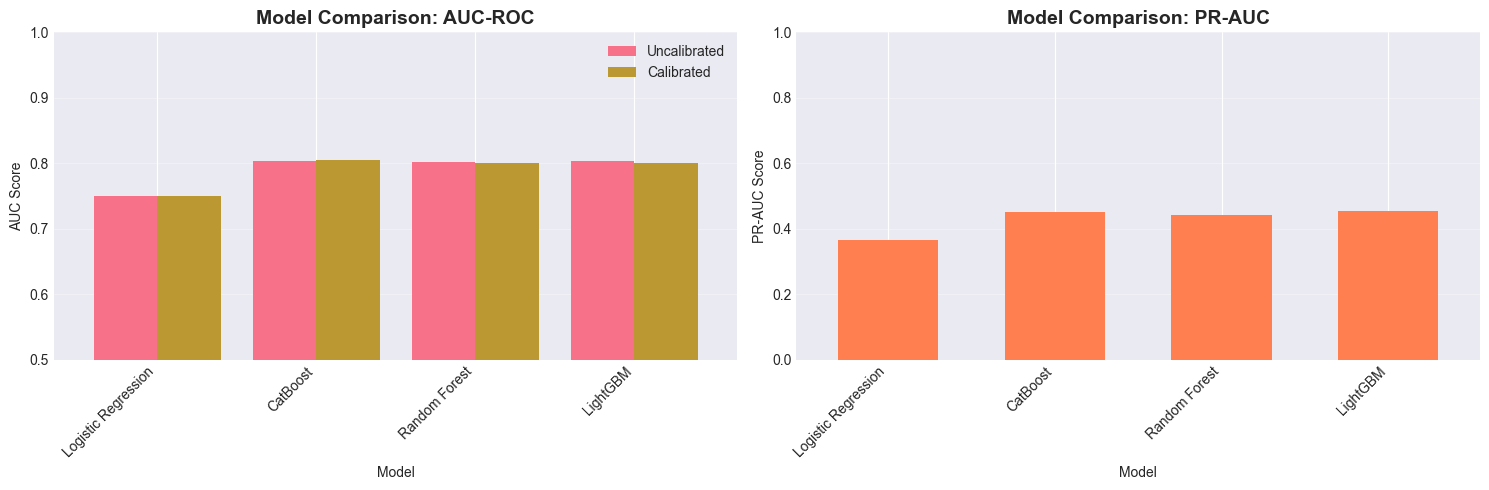

✓ Plot saved: outputs/evaluation/model_comparison.png


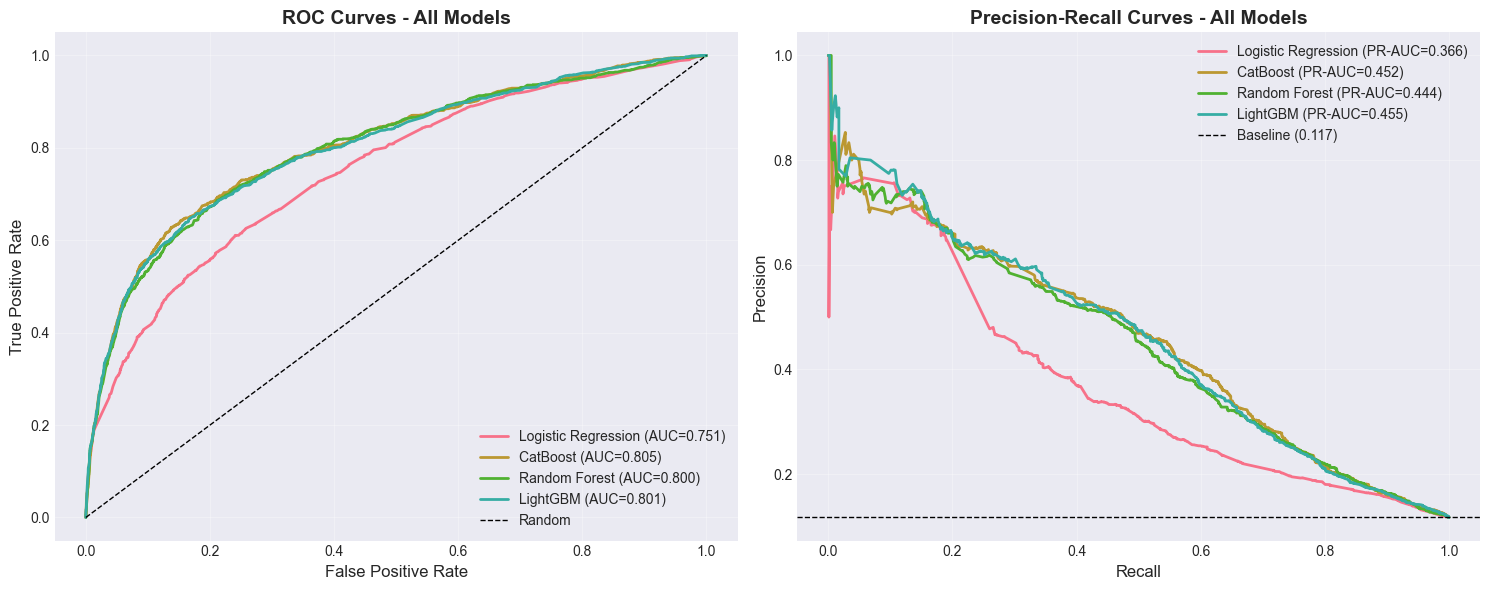

✓ Plot saved: outputs/evaluation/roc_pr_curves.png


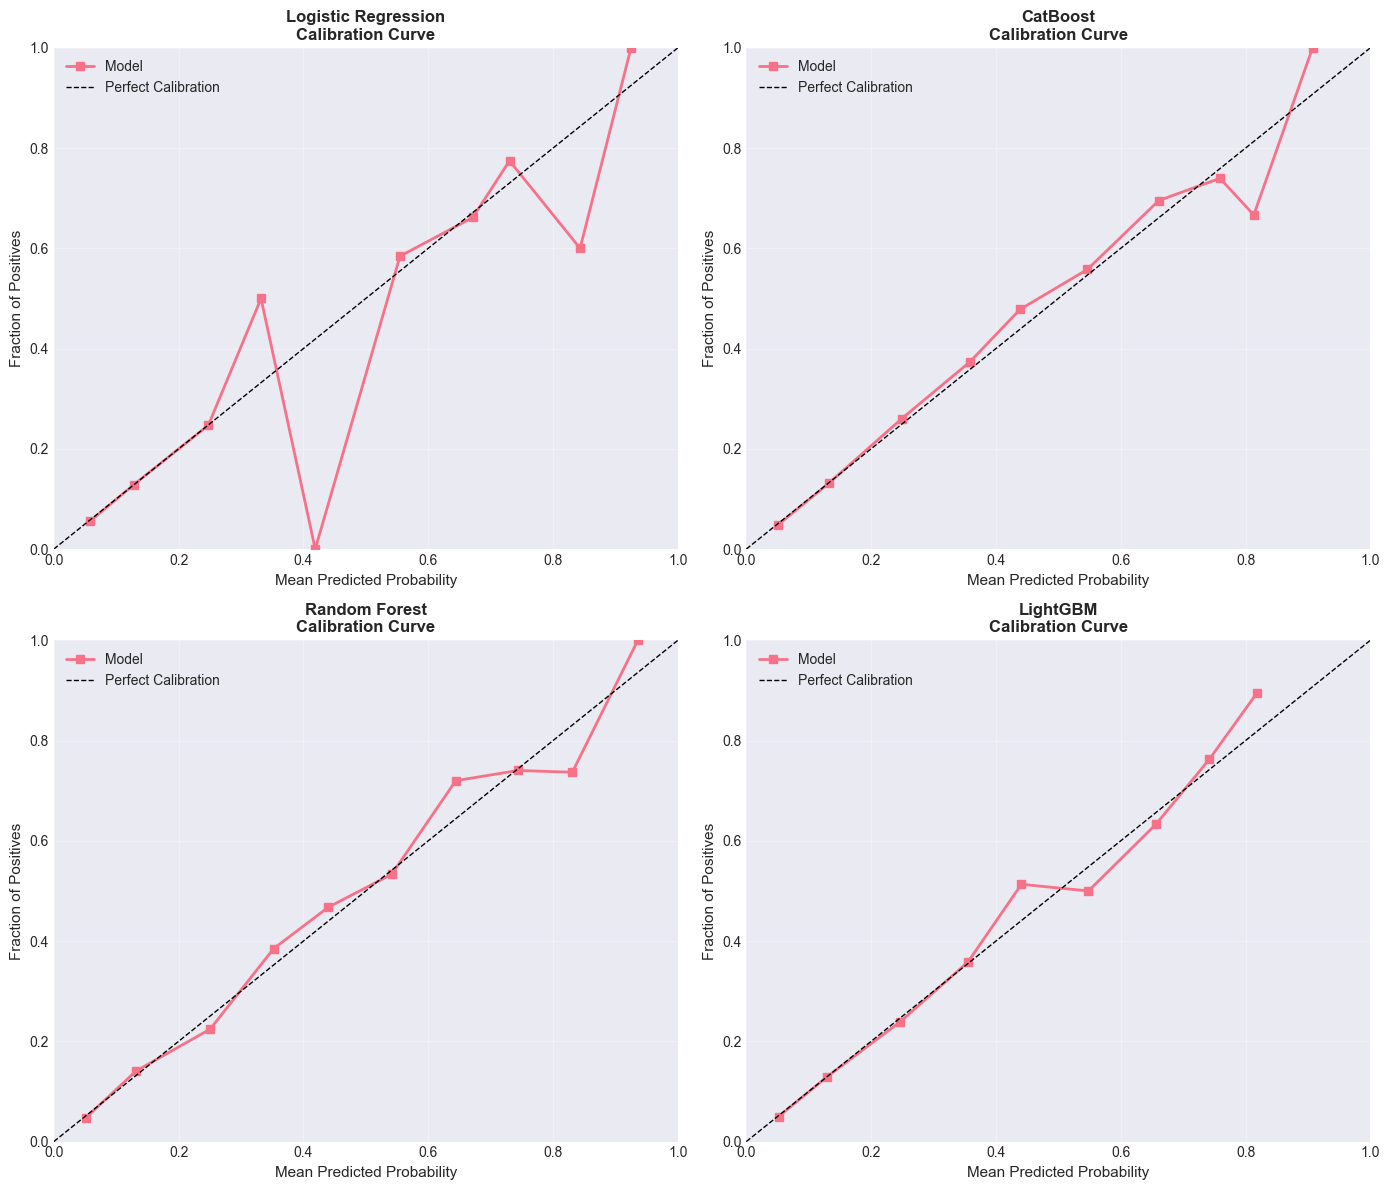

✓ Plot saved: outputs/evaluation/calibration_curves.png


In [9]:
def plot_model_comparison(results_df):

    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # AUC comparison
    ax = axes[0]
    results_df[['AUC (Uncalibrated)', 'AUC (Calibrated)']].plot(
        kind='bar', ax=ax, width=0.8
    )
    ax.set_title('Model Comparison: AUC-ROC', fontsize=14, fontweight='bold')
    ax.set_ylabel('AUC Score')
    ax.set_xlabel('Model')
    ax.legend(['Uncalibrated', 'Calibrated'])
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim([0.5, 1.0])

    # PR-AUC comparison
    ax = axes[1]
    results_df['PR-AUC'].plot(kind='bar', ax=ax, color='coral', width=0.6)
    ax.set_title('Model Comparison: PR-AUC', fontsize=14, fontweight='bold')
    ax.set_ylabel('PR-AUC Score')
    ax.set_xlabel('Model')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim([0, 1.0])

    plt.tight_layout()

    # Save
    Path('outputs/evaluation').mkdir(parents=True, exist_ok=True)
    plt.savefig('outputs/evaluation/model_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("✓ Plot saved: outputs/evaluation/model_comparison.png")

plot_model_comparison(results_df)

def plot_roc_pr_curves(results, y_test):
    """
    Plot ROC dan Precision-Recall curves untuk semua model
    """
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # ROC Curve
    ax = axes[0]
    for model_name, result in results.items():
        fpr, tpr, _ = roc_curve(y_test, result['y_pred_proba'])
        auc = result['auc_calibrated']
        ax.plot(fpr, tpr, label=f'{model_name} (AUC={auc:.3f})', linewidth=2)

    ax.plot([0, 1], [0, 1], 'k--', label='Random', linewidth=1)
    ax.set_xlabel('False Positive Rate', fontsize=12)
    ax.set_ylabel('True Positive Rate', fontsize=12)
    ax.set_title('ROC Curves - All Models', fontsize=14, fontweight='bold')
    ax.legend(loc='lower right')
    ax.grid(alpha=0.3)

    # Precision-Recall Curve
    ax = axes[1]
    for model_name, result in results.items():
        precision, recall, _ = precision_recall_curve(y_test, result['y_pred_proba'])
        pr_auc = result['pr_auc']
        ax.plot(recall, precision, label=f'{model_name} (PR-AUC={pr_auc:.3f})', linewidth=2)

    # Baseline
    baseline = y_test.mean()
    ax.axhline(y=baseline, color='k', linestyle='--', label=f'Baseline ({baseline:.3f})', linewidth=1)

    ax.set_xlabel('Recall', fontsize=12)
    ax.set_ylabel('Precision', fontsize=12)
    ax.set_title('Precision-Recall Curves - All Models', fontsize=14, fontweight='bold')
    ax.legend(loc='best')
    ax.grid(alpha=0.3)

    plt.tight_layout()
    plt.savefig('outputs/evaluation/roc_pr_curves.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("✓ Plot saved: outputs/evaluation/roc_pr_curves.png")

plot_roc_pr_curves(results, y_test)

def plot_calibration_curves(calibrated_models, X_test, y_test):
    """
    Plot calibration curves untuk melihat kualitas probability estimates
    """
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    axes = axes.ravel()

    for idx, (model_name, model) in enumerate(calibrated_models.items()):
        ax = axes[idx]

        y_pred_proba = model.predict_proba(X_test)[:, 1]

        # Calculate calibration curve
        fraction_of_positives, mean_predicted_value = calibration_curve(
            y_test, y_pred_proba, n_bins=10, strategy='uniform'
        )

        # Plot
        ax.plot(mean_predicted_value, fraction_of_positives, 's-', label='Model', linewidth=2)
        ax.plot([0, 1], [0, 1], 'k--', label='Perfect Calibration', linewidth=1)

        ax.set_xlabel('Mean Predicted Probability', fontsize=11)
        ax.set_ylabel('Fraction of Positives', fontsize=11)
        ax.set_title(f'{model_name}\nCalibration Curve', fontsize=12, fontweight='bold')
        ax.legend(loc='upper left')
        ax.grid(alpha=0.3)
        ax.set_xlim([0, 1])
        ax.set_ylim([0, 1])

    plt.tight_layout()
    plt.savefig('outputs/evaluation/calibration_curves.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("✓ Plot saved: outputs/evaluation/calibration_curves.png")

plot_calibration_curves(calibrated_models, X_test_scaled, y_test)

# 9. Uplift Analysis

UPLIFT ANALYSIS - Lead Scoring Effectiveness

Logistic Regression:
  Top 10%: Capture  366/1058 positives ( 34.6%)
  Top 20%: Capture  543/1058 positives ( 51.3%)
  Top 30%: Capture  660/1058 positives ( 62.4%)
  Top 50%: Capture  839/1058 positives ( 79.3%)

CatBoost:
  Top 10%: Capture  469/1058 positives ( 44.3%)
  Top 20%: Capture  668/1058 positives ( 63.1%)
  Top 30%: Capture  761/1058 positives ( 71.9%)
  Top 50%: Capture  884/1058 positives ( 83.6%)

Random Forest:
  Top 10%: Capture  461/1058 positives ( 43.6%)
  Top 20%: Capture  645/1058 positives ( 61.0%)
  Top 30%: Capture  755/1058 positives ( 71.4%)
  Top 50%: Capture  886/1058 positives ( 83.7%)

LightGBM:
  Top 10%: Capture  465/1058 positives ( 44.0%)
  Top 20%: Capture  650/1058 positives ( 61.4%)
  Top 30%: Capture  751/1058 positives ( 71.0%)
  Top 50%: Capture  877/1058 positives ( 82.9%)



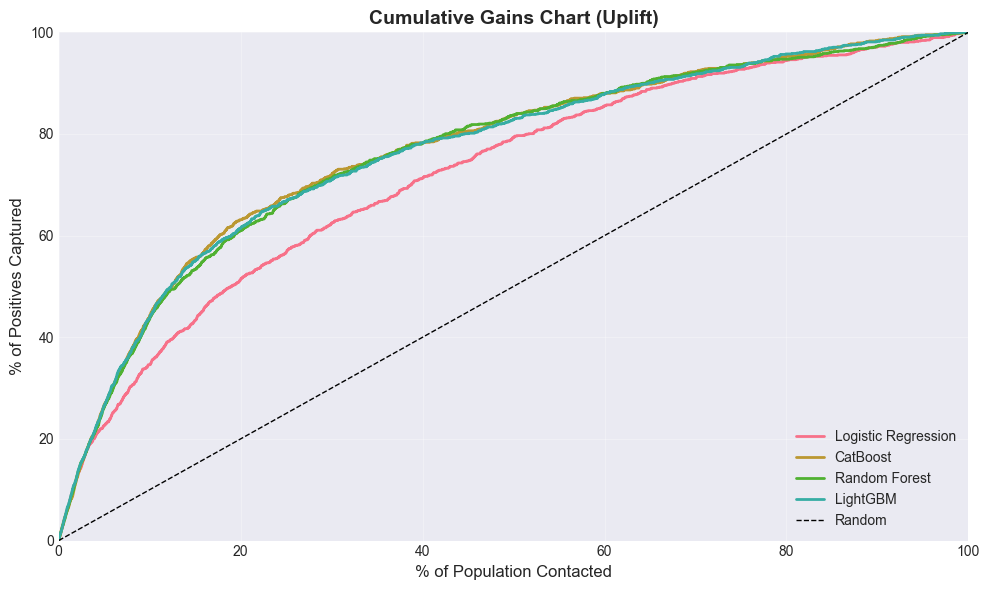

✓ Plot saved: outputs/evaluation/uplift_curve.png


In [10]:
def uplift_analysis(results, y_test, top_percentages=[10, 20, 30]):

    uplift_results = {}

    print("="*80)
    print("UPLIFT ANALYSIS - Lead Scoring Effectiveness")
    print("="*80)

    for model_name, result in results.items():
        y_pred_proba = result['y_pred_proba']

        # Create DataFrame for analysis
        df_uplift = pd.DataFrame({
            'y_true': y_test,
            'y_score': y_pred_proba
        })
        df_uplift = df_uplift.sort_values('y_score', ascending=False).reset_index(drop=True)
        df_uplift['cumsum_positive'] = df_uplift['y_true'].cumsum()
        df_uplift['cumsum_total'] = np.arange(1, len(df_uplift) + 1)

        total_positives = y_test.sum()

        print(f"\n{model_name}:")
        model_uplift = {}

        for pct in top_percentages:
            n_samples = int(len(df_uplift) * pct / 100)
            captured = df_uplift.iloc[:n_samples]['y_true'].sum()
            capture_rate = captured / total_positives * 100

            print(f"  Top {pct:2d}%: Capture {captured:4d}/{total_positives} positives ({capture_rate:5.1f}%)")

            model_uplift[f'top_{pct}pct'] = {
                'n_samples': n_samples,
                'captured': captured,
                'capture_rate': capture_rate
            }

        uplift_results[model_name] = model_uplift

    print("\n" + "="*80)

    return uplift_results

uplift_results = uplift_analysis(results, y_test, top_percentages=[10, 20, 30, 50])

def plot_uplift_curves(results, y_test):
    """
    Visualisasi uplift curves untuk semua model
    """
    fig, ax = plt.subplots(figsize=(10, 6))

    for model_name, result in results.items():
        y_pred_proba = result['y_pred_proba']

        # Sort by predicted probability
        df_uplift = pd.DataFrame({
            'y_true': y_test.values,
            'y_score': y_pred_proba
        })
        df_uplift = df_uplift.sort_values('y_score', ascending=False).reset_index(drop=True)

        # Calculate cumulative gains
        cumsum_positive = df_uplift['y_true'].cumsum()
        total_positive = df_uplift['y_true'].sum()

        # Percentage of population vs percentage of positives captured
        pct_population = np.arange(1, len(df_uplift) + 1) / len(df_uplift) * 100
        pct_captured = cumsum_positive / total_positive * 100

        ax.plot(pct_population, pct_captured, label=model_name, linewidth=2)

    # Baseline (random)
    ax.plot([0, 100], [0, 100], 'k--', label='Random', linewidth=1)

    ax.set_xlabel('% of Population Contacted', fontsize=12)
    ax.set_ylabel('% of Positives Captured', fontsize=12)
    ax.set_title('Cumulative Gains Chart (Uplift)', fontsize=14, fontweight='bold')
    ax.legend(loc='lower right')
    ax.grid(alpha=0.3)
    ax.set_xlim([0, 100])
    ax.set_ylim([0, 100])

    plt.tight_layout()
    plt.savefig('outputs/evaluation/uplift_curve.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("✓ Plot saved: outputs/evaluation/uplift_curve.png")

plot_uplift_curves(results, y_test)

# 10. Select Best Model & SHAP Analysis

BEST MODEL SELECTION

Best model: CatBoost
AUC (Calibrated): 0.8046
PR-AUC: 0.4523
SHAP ANALYSIS - CatBoost


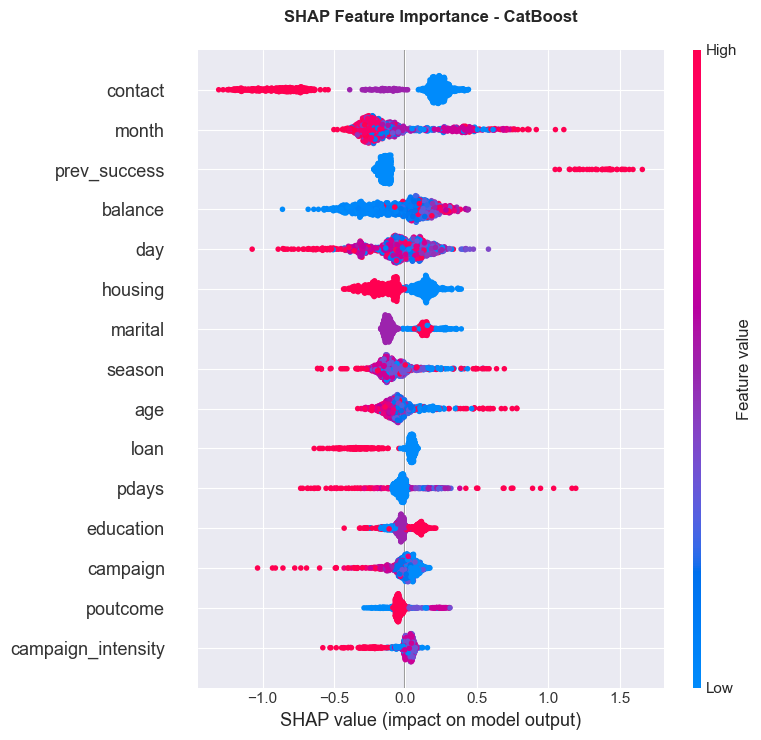


Top 10 Most Important Features:
     feature  importance
     contact    0.425185
       month    0.248868
prev_success    0.193044
     balance    0.185286
         day    0.158123
     housing    0.157455
     marital    0.131624
      season    0.123986
         age    0.103022
        loan    0.089976

✓ SHAP plot saved: outputs/evaluation/shap_summary_CatBoost.png


In [11]:
best_model_name = results_df['AUC (Calibrated)'].idxmax()
best_model = calibrated_models[best_model_name]

print("="*80)
print("BEST MODEL SELECTION")
print("="*80)
print(f"\nBest model: {best_model_name}")
print(f"AUC (Calibrated): {results_df.loc[best_model_name, 'AUC (Calibrated)']:.4f}")
print(f"PR-AUC: {results_df.loc[best_model_name, 'PR-AUC']:.4f}")

def shap_analysis(model, X_train, X_test, feature_names, model_name):

    print("="*80)
    print(f"SHAP ANALYSIS - {model_name}")
    print("="*80)

    # Get base estimator from calibrated model
    if hasattr(model, 'calibrated_classifiers_'):
        base_model = model.calibrated_classifiers_[0].estimator
    else:
        base_model = model

    # Create SHAP explainer
    # Use TreeExplainer for tree-based models
    if model_name in ['XGBoost', 'LightGBM', 'CatBoost', 'Random Forest']:
        explainer = shap.TreeExplainer(base_model)
        shap_values = explainer.shap_values(X_test[:1000])  # Sample untuk speed

        # Handle different SHAP value formats
        if isinstance(shap_values, list):
            shap_values = shap_values[1]  # Get positive class
    else:
        explainer = shap.Explainer(base_model, X_train[:500])
        shap_values = explainer(X_test[:1000])
        if hasattr(shap_values, 'values'):
            shap_values = shap_values.values

    # Summary plot
    plt.figure(figsize=(10, 8))
    shap.summary_plot(
        shap_values,
        X_test[:1000],
        feature_names=feature_names,
        show=False,
        max_display=15
    )
    plt.title(f'SHAP Feature Importance - {model_name}',
              fontsize=12, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.savefig(f'outputs/evaluation/shap_summary_{model_name.replace(" ", "_")}.png',
                dpi=300, bbox_inches='tight')
    plt.show()

    # Feature importance
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': np.abs(shap_values).mean(axis=0)
    }).sort_values('importance', ascending=False)

    print(f"\nTop 10 Most Important Features:")
    print(feature_importance.head(10).to_string(index=False))

    print(f"\n✓ SHAP plot saved: outputs/evaluation/shap_summary_{model_name.replace(' ', '_')}.png")

    return feature_importance, explainer, shap_values

# Run SHAP analysis
feature_importance, shap_explainer, shap_values_test = shap_analysis(
    best_model,
    X_train_scaled,
    X_test_scaled,
    X_train.columns.tolist(),
    best_model_name
)

# 11. Cost Matrix Simulation

COST MATRIX SIMULATION - Business Profit Optimization

Assumptions:
  - Gain per True Positive (TP):  IDR 150,000
  - Cost per False Positive (FP): IDR 5,000
  - Cost per False Negative (FN): IDR 100,000
  - True Negative (TN): IDR 0 (no action, no cost/benefit)


THRESHOLD SWEEPING RESULTS
 threshold  TP   FP   FN   TN  expected_profit
      0.10 738 1754  320 6231         69930000
      0.15 634  961  424 7024         47895000
      0.20 585  742  473 7243         36740000
      0.25 549  633  509 7352         28285000
      0.30 510  529  548 7456         19055000
      0.35 461  424  597 7561          7330000
      0.40 356  270  702 7715        -18150000
      0.45 263  153  795 7832        -40815000
      0.50 203  103  855 7882        -55565000
      0.55 173   79  885 7906        -62945000
      0.60 150   61  908 7924        -68605000
      0.65 117   49  941 7936        -76795000
      0.70  61   22  997 7963        -90660000
      0.75  40   10 1018 7975        -95850000
   

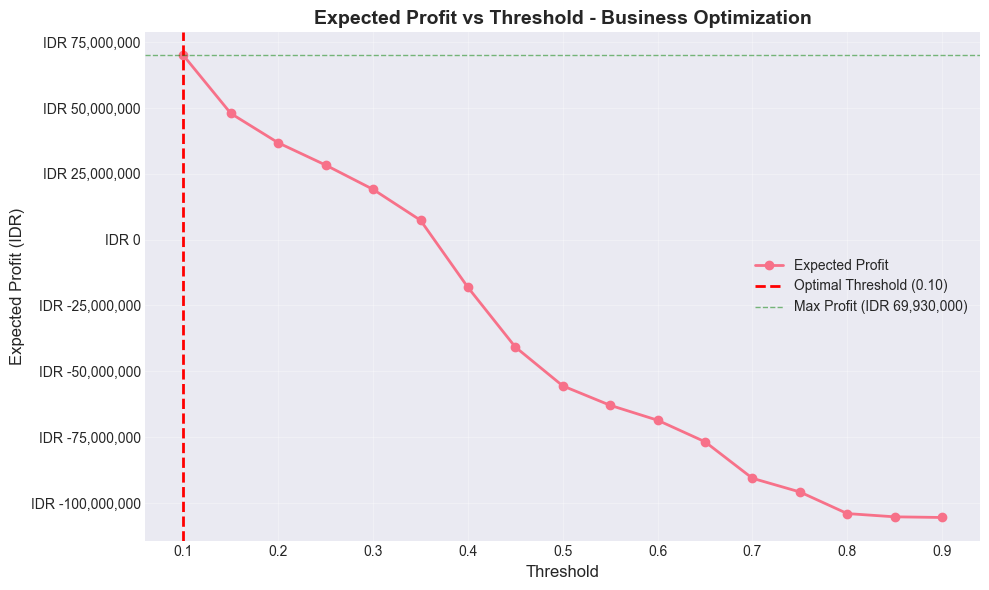


✓ Plot saved: outputs/evaluation/cost_matrix_profit_curve.png


In [12]:
def cost_matrix_simulation(y_test, y_pred_proba,
                           gain_TP=150000, cost_FP=5000, cost_FN=100000):
    """
    Cost Matrix Simulation untuk business profit optimization

    Parameters:
    -----------
    y_test : array-like
        True labels
    y_pred_proba : array-like
        Predicted probabilities
    gain_TP : float
        Gain dari True Positive (customer subscribe)
    cost_FP : float
        Cost dari False Positive (call tapi tidak subscribe)
    cost_FN : float
        Cost dari False Negative (tidak call tapi sebenarnya mau subscribe)

    Returns:
    --------
    cost_matrix_results : dict
        Dictionary berisi optimal threshold dan expected profit
    """

    print("="*80)
    print("COST MATRIX SIMULATION - Business Profit Optimization")
    print("="*80)
    print(f"\nAssumptions:")
    print(f"  - Gain per True Positive (TP):  IDR {gain_TP:,}")
    print(f"  - Cost per False Positive (FP): IDR {cost_FP:,}")
    print(f"  - Cost per False Negative (FN): IDR {cost_FN:,}")
    print(f"  - True Negative (TN): IDR 0 (no action, no cost/benefit)")
    print()

    # Threshold sweeping dari 0.10 sampai 0.90 dengan step 0.05
    thresholds = np.arange(0.10, 0.91, 0.05)

    results_list = []

    for threshold in thresholds:
        # Predict binary class based on threshold
        y_pred = (y_pred_proba >= threshold).astype(int)

        # Calculate confusion matrix components
        TP = ((y_pred == 1) & (y_test == 1)).sum()
        FP = ((y_pred == 1) & (y_test == 0)).sum()
        FN = ((y_pred == 0) & (y_test == 1)).sum()
        TN = ((y_pred == 0) & (y_test == 0)).sum()

        # Calculate expected profit
        # TN bernilai 0 (tidak memberi cost/benefit)
        expected_profit = (TP * gain_TP) - (FP * cost_FP) - (FN * cost_FN)

        results_list.append({
            'threshold': threshold,
            'TP': TP,
            'FP': FP,
            'FN': FN,
            'TN': TN,
            'expected_profit': expected_profit
        })

    # Convert to DataFrame
    cost_matrix_df = pd.DataFrame(results_list)

    # Find optimal threshold
    optimal_idx = cost_matrix_df['expected_profit'].idxmax()
    optimal_threshold = cost_matrix_df.loc[optimal_idx, 'threshold']
    max_profit = cost_matrix_df.loc[optimal_idx, 'expected_profit']

    print("\n" + "="*80)
    print("THRESHOLD SWEEPING RESULTS")
    print("="*80)
    print(cost_matrix_df.to_string(index=False))

    print("\n" + "="*80)
    print("OPTIMAL THRESHOLD & PROFIT")
    print("="*80)
    print(f"  Optimal threshold: {optimal_threshold:.2f}")
    print(f"  Maximum expected profit: IDR {max_profit:,.0f}")

    # Convert optimal threshold to TOP-X%
    n_samples_above_threshold = (y_pred_proba >= optimal_threshold).sum()
    optimal_top_x_percent = (n_samples_above_threshold / len(y_pred_proba)) * 100

    print(f"\n  Optimal top-X% based on business profit: {optimal_top_x_percent:.1f}%")
    print(f"  (This means targeting top {optimal_top_x_percent:.1f}% of leads maximizes profit)")

    # Plot Expected Profit vs Threshold
    fig, ax = plt.subplots(figsize=(10, 6))

    ax.plot(cost_matrix_df['threshold'], cost_matrix_df['expected_profit'],
            marker='o', linewidth=2, markersize=6, label='Expected Profit')

    # Mark optimal point
    ax.axvline(x=optimal_threshold, color='red', linestyle='--',
               linewidth=2, label=f'Optimal Threshold ({optimal_threshold:.2f})')
    ax.axhline(y=max_profit, color='green', linestyle='--',
               linewidth=1, alpha=0.5, label=f'Max Profit (IDR {max_profit:,.0f})')

    ax.set_xlabel('Threshold', fontsize=12)
    ax.set_ylabel('Expected Profit (IDR)', fontsize=12)
    ax.set_title('Expected Profit vs Threshold - Business Optimization',
                 fontsize=14, fontweight='bold')
    ax.legend(loc='best')
    ax.grid(alpha=0.3)

    # Format y-axis dengan thousand separator
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'IDR {x:,.0f}'))

    plt.tight_layout()

    # Save plot
    Path('outputs/evaluation').mkdir(parents=True, exist_ok=True)
    plt.savefig('outputs/evaluation/cost_matrix_profit_curve.png',
                dpi=300, bbox_inches='tight')
    plt.show()

    print(f"\n✓ Plot saved: outputs/evaluation/cost_matrix_profit_curve.png")

    # Return results
    cost_matrix_results = {
        'optimal_threshold': float(optimal_threshold),
        'optimal_top_x_percent': float(optimal_top_x_percent),
        'maximum_expected_profit': float(max_profit),
        'optimal_confusion_matrix': {
            'TP': int(cost_matrix_df.loc[optimal_idx, 'TP']),
            'FP': int(cost_matrix_df.loc[optimal_idx, 'FP']),
            'FN': int(cost_matrix_df.loc[optimal_idx, 'FN']),
            'TN': int(cost_matrix_df.loc[optimal_idx, 'TN'])
        },
        'assumptions': {
            'gain_TP': float(gain_TP),
            'cost_FP': float(cost_FP),
            'cost_FN': float(cost_FN)
        },
        'full_sweep_results': cost_matrix_df
    }

    return cost_matrix_results

# Run cost matrix simulation
cost_matrix_results = cost_matrix_simulation(
    y_test=y_test,
    y_pred_proba=results[best_model_name]['y_pred_proba'],
    gain_TP=150000,  # IDR 150k per subscription
    cost_FP=5000,    # IDR 5k per unsuccessful call
    cost_FN=100000   # IDR 100k opportunity cost per missed lead
)

# 12. Reason Codes (Top-5 SHAP per Customer)

In [13]:
def generate_reason_codes(model, X_test, y_pred_proba, feature_names,
                          shap_explainer=None, model_name=''):
    """
    Generate reason codes (Top-5 SHAP explanations) untuk setiap customer

    Parameters:
    -----------
    model : trained model
        Model yang sudah dikalibrasi
    X_test : DataFrame
        Test features (scaled)
    y_pred_proba : array-like
        Predicted probabilities
    feature_names : list
        List nama fitur
    shap_explainer : SHAP explainer (optional)
        SHAP explainer object (jika sudah ada)
    model_name : str
        Nama model untuk logging

    Returns:
    --------
    reason_codes_df : DataFrame
        DataFrame berisi customer_id, probability, dan reason codes
    """

    print("="*80)
    print("REASON CODES GENERATION - Top-5 SHAP Explanations per Customer")
    print("="*80)
    print(f"Model: {model_name}")
    print(f"Total customers: {len(X_test):,}")
    print()

    # Get base estimator from calibrated model
    if hasattr(model, 'calibrated_classifiers_'):
        base_model = model.calibrated_classifiers_[0].estimator
    else:
        base_model = model

    # Create SHAP explainer if not provided
    if shap_explainer is None:
        print("Creating SHAP explainer...")
        if model_name in ['XGBoost', 'LightGBM', 'CatBoost', 'Random Forest']:
            shap_explainer = shap.TreeExplainer(base_model)
        else:
            # Use sample untuk KernelExplainer (memory efficient)
            shap_explainer = shap.Explainer(base_model, X_test[:500])

    # Calculate SHAP values untuk semua test samples
    print("Calculating SHAP values for all test samples...")
    print("(This may take a few minutes...)")

    shap_values_full = shap_explainer.shap_values(X_test)

    # Handle different SHAP value formats
    if isinstance(shap_values_full, list):
        shap_values_full = shap_values_full[1]  # Get positive class

    print(f"✓ SHAP values calculated: {shap_values_full.shape}")

    # Generate reason codes untuk setiap customer
    reason_codes_list = []

    for idx in range(len(X_test)):
        # Get SHAP values untuk customer ini
        customer_shap = shap_values_full[idx]

        # Get top 5 features by absolute SHAP value
        top_5_indices = np.argsort(np.abs(customer_shap))[-5:][::-1]

        # Build reason codes
        top_5_features = []
        reason_codes_str = []

        for feat_idx in top_5_indices:
            feature_name = feature_names[feat_idx]
            shap_value = customer_shap[feat_idx]

            # Add + or - sign
            sign = '+' if shap_value > 0 else '-'
            reason_code = f"{sign} {feature_name}"

            top_5_features.append(feature_name)
            reason_codes_str.append(reason_code)

        # Store results
        reason_codes_list.append({
            'customer_id': idx,
            'probability': y_pred_proba[idx],
            'top_5_features': top_5_features,
            'reason_codes': ', '.join(reason_codes_str)
        })

    # Convert to DataFrame
    reason_codes_df = pd.DataFrame(reason_codes_list)

    # Sort by probability (descending)
    reason_codes_df = reason_codes_df.sort_values('probability', ascending=False).reset_index(drop=True)

    print(f"\n✓ Reason codes generated for {len(reason_codes_df):,} customers")

    # Show sample
    print("\n" + "="*80)
    print("SAMPLE REASON CODES (Top 5 High-Probability Customers)")
    print("="*80)
    print(reason_codes_df.head(5)[['customer_id', 'probability', 'reason_codes']].to_string(index=False))

    # Save to CSV
    Path('outputs/reason_codes').mkdir(parents=True, exist_ok=True)
    csv_path = 'outputs/reason_codes/reason_codes_test.csv'
    reason_codes_df.to_csv(csv_path, index=False)

    print(f"\n✓ Reason codes saved: {csv_path}")

    return reason_codes_df, shap_values_full

# Generate reason codes
reason_codes_df, shap_values_full = generate_reason_codes(
    model=best_model,
    X_test=X_test_scaled,
    y_pred_proba=results[best_model_name]['y_pred_proba'],
    feature_names=X_train.columns.tolist(),
    shap_explainer=shap_explainer,  # Re-use explainer dari SHAP analysis
    model_name=best_model_name
)

# Save to JSON
json_path = 'outputs/reason_codes/reason_codes_test.json'
reason_codes_df.to_json(json_path, orient='records', indent=2)
print(f"✓ Reason codes saved (JSON): {json_path}")

REASON CODES GENERATION - Top-5 SHAP Explanations per Customer
Model: CatBoost
Total customers: 9,043

Calculating SHAP values for all test samples...
(This may take a few minutes...)
✓ SHAP values calculated: (9043, 19)

✓ Reason codes generated for 9,043 customers

SAMPLE REASON CODES (Top 5 High-Probability Customers)
 customer_id  probability                                                  reason_codes
        2399     0.907492 + prev_success, + season, + age_group, + poutcome, + previous
         646     0.888462         + prev_success, + pdays, + age, + contact, + poutcome
        6179     0.827561         + prev_success, + month, + age, + contact, + poutcome
        7971     0.800518       + prev_success, + month, + contact, + poutcome, + pdays
        2984     0.800518       + prev_success, + month, + contact, + poutcome, + pdays

✓ Reason codes saved: outputs/reason_codes/reason_codes_test.csv
✓ Reason codes saved (JSON): outputs/reason_codes/reason_codes_test.json


# 13. Single Input Inference Function untuk Reason Codes

In [14]:
def get_reason_codes_single_input(single_input_dict,
                                  model, preprocessor, label_encoders,
                                  feature_names, shap_explainer):
    """
    Generate reason codes untuk single customer input (untuk portal web)

    Parameters:
    -----------
    single_input_dict : dict
        Dictionary berisi customer data (raw format, sebelum preprocessing)
        Example: {'age': 35, 'job': 'technician', 'marital': 'married', ...}
    model : trained model
        Calibrated model
    preprocessor : fitted preprocessor
        StandardScaler yang sudah di-fit
    label_encoders : dict
        Dictionary label encoders untuk categorical features
    feature_names : list
        List nama fitur (setelah feature engineering)
    shap_explainer : SHAP explainer
        SHAP explainer object

    Returns:
    --------
    result : dict
        JSON-friendly dictionary berisi:
        - customer_id
        - probability
        - prediction
        - risk_level
        - top_5_features
        - reason_codes
    """

    # STEP 1: Convert dict to DataFrame
    X_single = pd.DataFrame([single_input_dict])

    # STEP 2: Feature engineering
    X_single_featured, _ = create_features(X_single, fit=False, label_encoders=label_encoders)

    # STEP 3: Ensure correct column order
    X_single_featured = X_single_featured[feature_names]

    # STEP 4: Preprocessing (scaling)
    X_single_scaled = preprocessor.transform(X_single_featured)
    X_single_scaled = pd.DataFrame(X_single_scaled, columns=feature_names)

    # STEP 5: Predict probability
    probability = model.predict_proba(X_single_scaled)[0, 1]
    prediction = int(model.predict(X_single_scaled)[0])

    # STEP 6: Risk level
    if probability < 0.3:
        risk_level = 'Low'
    elif probability < 0.6:
        risk_level = 'Medium'
    else:
        risk_level = 'High'

    # STEP 7: Calculate SHAP values
    # Get base estimator
    if hasattr(model, 'calibrated_classifiers_'):
        base_model = model.calibrated_classifiers_[0].estimator
    else:
        base_model = model

    shap_values_single = shap_explainer.shap_values(X_single_scaled)

    # Handle different SHAP formats
    if isinstance(shap_values_single, list):
        shap_values_single = shap_values_single[1][0]  # Get positive class, first sample
    else:
        shap_values_single = shap_values_single[0]

    # STEP 8: Get top 5 features
    top_5_indices = np.argsort(np.abs(shap_values_single))[-5:][::-1]

    top_5_features = []
    reason_codes_list = []

    for feat_idx in top_5_indices:
        feature_name = feature_names[feat_idx]
        shap_value = shap_values_single[feat_idx]

        sign = '+' if shap_value > 0 else '-'
        reason_code = f"{sign} {feature_name}"

        top_5_features.append(feature_name)
        reason_codes_list.append(reason_code)

    # STEP 9: Build result dictionary
    result = {
        'customer_id': 'new_customer',  # Placeholder
        'probability': float(probability),
        'prediction': int(prediction),
        'prediction_label': 'Yes' if prediction == 1 else 'No',
        'risk_level': risk_level,
        'top_5_features': top_5_features,
        'reason_codes': ', '.join(reason_codes_list)
    }

    return result


# Example usage: Test dengan single input
print("\n" + "="*80)
print("TESTING: Single Input Inference (untuk Portal Web)")
print("="*80)

# Contoh input customer baru
print("\nRequired input columns (raw data):")
print(X_train_raw.columns.tolist())
print()

# SAMPLE CUSTOMER
sample_customer = {
    'age': 35,
    'job': 'technician',
    'marital': 'married',
    'education': 'tertiary',
    'default': 'no',
    'balance': 1500,
    'housing': 'yes',
    'loan': 'no',
    'contact': 'cellular',
    'day': 15,
    'month': 'may',
    'duration': 0,
    'campaign': 2,
    'pdays': 999,
    'previous': 0,
    'poutcome': 'unknown'
}

# Validation
missing_cols = set(X_train_raw.columns) - set(sample_customer.keys())
if missing_cols:
    print(f"⚠️  WARNING: Missing columns in sample_customer: {missing_cols}")
    print("Adding missing columns with default values...")
    # Add missing columns with sample values from X_train_raw
    for col in missing_cols:
        sample_customer[col] = X_train_raw[col].iloc[0]

extra_cols = set(sample_customer.keys()) - set(X_train_raw.columns)
if extra_cols:
    print(f"⚠️  WARNING: Extra columns in sample_customer (will be ignored): {extra_cols}")
    # Remove extra columns
    for col in extra_cols:
        del sample_customer[col]

print("✓ Sample customer data prepared")
print(f"  Columns: {len(sample_customer)}")
print()

# Get reason codes
try:
    inference_result = get_reason_codes_single_input(
        single_input_dict=sample_customer,
        model=best_model,
        preprocessor=preprocessor,
        label_encoders=label_encoders,
        feature_names=X_train.columns.tolist(),
        shap_explainer=shap_explainer
    )

    print("\n✅ Inference Result (JSON format):")
    print(json.dumps(inference_result, indent=2))

    print("\n" + "="*80)
    print("INTERPRETATION")
    print("="*80)
    print(f"Customer Profile:")
    print(f"  - Age: {sample_customer['age']} years")
    print(f"  - Job: {sample_customer['job']}")
    print(f"  - Balance: IDR {sample_customer['balance']:,}")
    print(f"  - Has Housing Loan: {sample_customer['housing']}")
    print(f"  - Campaign Count: {sample_customer['campaign']}")
    print()
    print(f"Prediction:")
    print(f"  - Probability: {inference_result['probability']:.2%}")
    print(f"  - Prediction: {inference_result['prediction_label']}")
    print(f"  - Risk Level: {inference_result['risk_level']}")
    print()
    print(f"Top 5 Contributing Features (Reason Codes):")
    for i, code in enumerate(inference_result['reason_codes'].split(', '), 1):
        impact = "increases" if code.startswith('+') else "decreases"
        feature = code[2:]  # Remove "+ " or "- "
        print(f"  {i}. {feature} → {impact} subscription likelihood")

except Exception as e:
    print(f"\n❌ Error during inference: {e}")
    print("\nDebug info:")
    print(f"  - X_train_raw columns: {X_train_raw.columns.tolist()}")
    print(f"  - X_train columns (after FE): {X_train.columns.tolist()}")
    print(f"  - Sample customer keys: {list(sample_customer.keys())}")
    import traceback
    traceback.print_exc()


TESTING: Single Input Inference (untuk Portal Web)

Required input columns (raw data):
['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome']

✓ Sample customer data prepared
  Columns: 16

✓ Duration column removed
✓ Transformed 12 kolom pada TEST set menggunakan train encoder

✓ Feature engineering complete: 19 features

✅ Inference Result (JSON format):
{
  "customer_id": "new_customer",
  "probability": 0.20309875639903852,
  "prediction": 0,
  "prediction_label": "No",
  "risk_level": "Low",
  "top_5_features": [
    "pdays",
    "contact",
    "month",
    "housing",
    "poutcome"
  ],
  "reason_codes": "+ pdays, + contact, - month, - housing, - poutcome"
}

INTERPRETATION
Customer Profile:
  - Age: 35 years
  - Job: technician
  - Balance: IDR 1,500
  - Has Housing Loan: yes
  - Campaign Count: 2

Prediction:
  - Probability: 20.31%
  - Prediction: No
  - Risk Level: Lo

# 14. Model Card

In [15]:
from datetime import datetime
import json

# Helper function untuk convert numpy/pandas types ke Python native types
def convert_to_native(obj):
    """Convert numpy/pandas types to Python native types for JSON serialization"""
    if isinstance(obj, (np.integer, np.int64, np.int32)):
        return int(obj)
    elif isinstance(obj, (np.floating, np.float64, np.float32)):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, pd.Series):
        return obj.tolist()
    elif isinstance(obj, dict):
        return {key: convert_to_native(value) for key, value in obj.items()}
    elif isinstance(obj, list):
        return [convert_to_native(item) for item in obj]
    else:
        return obj

# Siapkan informasi model card
model_card = {
    "model_metadata": {
        "model_name": "Bank Marketing Campaign Lead Scoring Model",
        "model_version": "v2.0",  # Updated version
        "creation_date": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        "author": "Your Name / Team Name",
        "framework": best_model_name,
        "purpose": "Prediksi probabilitas customer akan subscribe term deposit (lead scoring untuk kampanye marketing)",
        "updates_in_v2": [
            "Added Cost Matrix Simulation untuk business profit optimization",
            "Added Reason Codes (Top-5 SHAP) untuk explainability di portal web"
        ]
    },

    "model_performance": {
        "best_model": best_model_name,
        "test_set_metrics": {
            "roc_auc_calibrated": float(results_df.loc[best_model_name, 'AUC (Calibrated)']),
            "roc_auc_uncalibrated": float(results_df.loc[best_model_name, 'AUC (Uncalibrated)']),
            "pr_auc": float(results_df.loc[best_model_name, 'PR-AUC'])
        },
        "tuning_performance": {
            "best_cv_auc": float(tuning_results[best_model_name]['best_cv_auc']),
            "best_params": convert_to_native(tuning_results[best_model_name]['best_params'])
        }
    },

    "feature_importance": {
        "top_10_features": feature_importance['feature'].head(10).tolist(),
        "top_10_importance_values": [float(x) for x in feature_importance['importance'].head(10)],
        "total_features": int(len(X_train.columns)),
        "feature_engineering_applied": [
            "Duration column removed (data leakage prevention)",
            "Age groups created (5 categories)",
            "Previous contact success indicator",
            "Campaign intensity categories (4 levels)",
            "Economic stability interaction term",
            "Month to season mapping",
            "All categorical features: Label Encoding",
            "All numeric features: Standard Scaling"
        ]
    },

    "business_impact": {
        "uplift_analysis": {
            "description": "Lead scoring effectiveness - targeting top segments",
            "top_10_pct": {
                "n_samples": int(uplift_results[best_model_name]['top_10pct']['n_samples']),
                "captured": int(uplift_results[best_model_name]['top_10pct']['captured']),
                "capture_rate": float(uplift_results[best_model_name]['top_10pct']['capture_rate'])
            },
            "top_20_pct": {
                "n_samples": int(uplift_results[best_model_name]['top_20pct']['n_samples']),
                "captured": int(uplift_results[best_model_name]['top_20pct']['captured']),
                "capture_rate": float(uplift_results[best_model_name]['top_20pct']['capture_rate'])
            },
            "top_30_pct": {
                "n_samples": int(uplift_results[best_model_name]['top_30pct']['n_samples']),
                "captured": int(uplift_results[best_model_name]['top_30pct']['captured']),
                "capture_rate": float(uplift_results[best_model_name]['top_30pct']['capture_rate'])
            },
            "top_50_pct": {
                "n_samples": int(uplift_results[best_model_name]['top_50pct']['n_samples']),
                "captured": int(uplift_results[best_model_name]['top_50pct']['captured']),
                "capture_rate": float(uplift_results[best_model_name]['top_50pct']['capture_rate'])
            }
        },
        "cost_matrix_analysis": {
            "description": "Business profit optimization menggunakan cost matrix",
            "optimal_threshold": cost_matrix_results['optimal_threshold'],
            "optimal_top_x_percent": cost_matrix_results['optimal_top_x_percent'],
            "maximum_expected_profit": cost_matrix_results['maximum_expected_profit'],
            "optimal_confusion_matrix": cost_matrix_results['optimal_confusion_matrix'],
            "assumptions": cost_matrix_results['assumptions']
        },
        "recommendation": f"Target top {cost_matrix_results['optimal_top_x_percent']:.1f}% leads untuk maximize profit (based on cost matrix simulation)"
    },

    "explainability": {
        "reason_codes": {
            "method": "SHAP Top-5 per customer",
            "description": "Menampilkan 5 fitur dengan kontribusi terbesar per pelanggan (+ untuk meningkatkan prediksi, - untuk menurunkan)",
            "example": {
                "customer_id": inference_result['customer_id'],
                "probability": inference_result['probability'],
                "reason_codes": inference_result['reason_codes']
            },
            "csv_output": "outputs/reason_codes/reason_codes_test.csv",
            "total_customers_explained": int(len(reason_codes_df))
        }
    },

    "data_info": {
        "training_samples": int(len(X_train_scaled)),
        "test_samples": int(len(X_test_scaled)),
        "features_used": int(len(X_train.columns)),
        "feature_names": X_train.columns.tolist(),
        "target_distribution_train": {
            "class_0": int((y_train == 0).sum()),
            "class_1": int((y_train == 1).sum()),
            "imbalance_ratio": float(round((y_train == 0).sum() / (y_train == 1).sum(), 2))
        },
        "target_distribution_test": {
            "class_0": int((y_test == 0).sum()),
            "class_1": int((y_test == 1).sum())
        }
    },

    "preprocessing": {
        "label_encoders_used": list(label_encoders.keys()),
        "scaling_method": "StandardScaler",
        "calibration_method": "Isotonic Regression (CalibratedClassifierCV)"
    },

    "model_limitations": [
        "Model dilatih pada data historis, performa bisa menurun jika behavior customer berubah",
        "Class imbalance handled melalui class_weight/scale_pos_weight, bukan SMOTE",
        "Feature importance berbasis SHAP - interpretasi hanya untuk model ini",
        "Threshold optimal berbeda antara business profit (cost matrix) vs statistical metrics",
        "Duration feature dihapus untuk menghindari data leakage"
    ],

    "monitoring_recommendations": [
        "Track conversion rate per decile setiap campaign",
        "Monitor feature drift (distribusi fitur berubah dari training data)",
        "Re-train model setiap 6 bulan atau jika performa turun >5%",
        "A/B testing untuk validasi uplift di production",
        "Monitor calibration quality secara berkala",
        "Track actual business profit vs expected profit dari cost matrix"
    ]
}

# Print Model Card
print("="*80)
print("MODEL CARD v2.0 - BANK MARKETING LEAD SCORING MODEL")
print("="*80)
print()

for section, content in model_card.items():
    print(f"\n{'='*80}")
    print(f"{section.upper().replace('_', ' ')}")
    print(f"{'='*80}")
    print(json.dumps(content, indent=2, ensure_ascii=False))

# Simpan Model Card ke file JSON
Path('outputs/model_card').mkdir(parents=True, exist_ok=True)
model_card_path = 'outputs/model_card/model_card_v2.json'
with open(model_card_path, 'w', encoding='utf-8') as f:
    json.dump(model_card, f, indent=2, ensure_ascii=False)

print(f"\n✅ Model Card v2.0 disimpan ke: {model_card_path}")

# Versi Markdown untuk dokumentasi
markdown_content = f"""# Bank Marketing Lead Scoring Model - Model Card v2.0

**Created:** {model_card['model_metadata']['creation_date']}
**Author:** {model_card['model_metadata']['author']}
**Framework:** {model_card['model_metadata']['framework']}
**Purpose:** {model_card['model_metadata']['purpose']}

**Updates in v2.0:**
{chr(10).join([f"- {item}" for item in model_card['model_metadata']['updates_in_v2']])}

---

## 📊 Model Performance

### Test Set Metrics
- **ROC-AUC (Calibrated):** {model_card['model_performance']['test_set_metrics']['roc_auc_calibrated']:.4f}
- **ROC-AUC (Uncalibrated):** {model_card['model_performance']['test_set_metrics']['roc_auc_uncalibrated']:.4f}
- **PR-AUC:** {model_card['model_performance']['test_set_metrics']['pr_auc']:.4f}

### Hyperparameter Tuning Results
- **Best CV AUC:** {model_card['model_performance']['tuning_performance']['best_cv_auc']:.4f}
- **Best Parameters:**
```json
{json.dumps(model_card['model_performance']['tuning_performance']['best_params'], indent=2)}
```

---

## 🎯 Business Impact

### Uplift Analysis

**Top 10% of Leads:**
- Samples: {model_card['business_impact']['uplift_analysis']['top_10_pct']['n_samples']:,}
- Positives Captured: {model_card['business_impact']['uplift_analysis']['top_10_pct']['captured']}
- Capture Rate: {model_card['business_impact']['uplift_analysis']['top_10_pct']['capture_rate']:.1f}%

**Top 20% of Leads:**
- Samples: {model_card['business_impact']['uplift_analysis']['top_20_pct']['n_samples']:,}
- Positives Captured: {model_card['business_impact']['uplift_analysis']['top_20_pct']['captured']}
- Capture Rate: {model_card['business_impact']['uplift_analysis']['top_20_pct']['capture_rate']:.1f}%

**Top 30% of Leads:**
- Samples: {model_card['business_impact']['uplift_analysis']['top_30_pct']['n_samples']:,}
- Positives Captured: {model_card['business_impact']['uplift_analysis']['top_30_pct']['captured']}
- Capture Rate: {model_card['business_impact']['uplift_analysis']['top_30_pct']['capture_rate']:.1f}%

**Top 50% of Leads:**
- Samples: {model_card['business_impact']['uplift_analysis']['top_50_pct']['n_samples']:,}
- Positives Captured: {model_card['business_impact']['uplift_analysis']['top_50_pct']['captured']}
- Capture Rate: {model_card['business_impact']['uplift_analysis']['top_50_pct']['capture_rate']:.1f}%

### 💰 Cost Matrix Analysis (NEW in v2.0)

**Business Profit Optimization:**
- **Optimal Threshold:** {model_card['business_impact']['cost_matrix_analysis']['optimal_threshold']:.2f}
- **Optimal Top-X%:** {model_card['business_impact']['cost_matrix_analysis']['optimal_top_x_percent']:.1f}%
- **Maximum Expected Profit:** IDR {model_card['business_impact']['cost_matrix_analysis']['maximum_expected_profit']:,.0f}

**Optimal Confusion Matrix:**
- TP: {model_card['business_impact']['cost_matrix_analysis']['optimal_confusion_matrix']['TP']}
- FP: {model_card['business_impact']['cost_matrix_analysis']['optimal_confusion_matrix']['FP']}
- FN: {model_card['business_impact']['cost_matrix_analysis']['optimal_confusion_matrix']['FN']}
- TN: {model_card['business_impact']['cost_matrix_analysis']['optimal_confusion_matrix']['TN']}

**Assumptions:**
- Gain per TP: IDR {model_card['business_impact']['cost_matrix_analysis']['assumptions']['gain_TP']:,}
- Cost per FP: IDR {model_card['business_impact']['cost_matrix_analysis']['assumptions']['cost_FP']:,}
- Cost per FN: IDR {model_card['business_impact']['cost_matrix_analysis']['assumptions']['cost_FN']:,}

**💡 Recommendation:** {model_card['business_impact']['recommendation']}

---

## 🔍 Top 10 Most Important Features (SHAP)

{chr(10).join([f"{i+1}. **{feat}** (SHAP: {val:.4f})" for i, (feat, val) in enumerate(zip(model_card['feature_importance']['top_10_features'], model_card['feature_importance']['top_10_importance_values']))])}

### Feature Engineering Applied:
{chr(10).join([f"- {item}" for item in model_card['feature_importance']['feature_engineering_applied']])}

---

## 💡 Explainability: Reason Codes (NEW in v2.0)

**Method:** {model_card['explainability']['reason_codes']['method']}
**Description:** {model_card['explainability']['reason_codes']['description']}

**Example:**
- Customer ID: {model_card['explainability']['reason_codes']['example']['customer_id']}
- Probability: {model_card['explainability']['reason_codes']['example']['probability']:.4f}
- Reason Codes: {model_card['explainability']['reason_codes']['example']['reason_codes']}

**Output:**
- CSV File: `{model_card['explainability']['reason_codes']['csv_output']}`
- Total Customers Explained: {model_card['explainability']['reason_codes']['total_customers_explained']:,}

---

## ⚠️ Model Limitations

{chr(10).join([f"- {item}" for item in model_card['model_limitations']])}

---

## 📈 Monitoring Recommendations

{chr(10).join([f"- {item}" for item in model_card['monitoring_recommendations']])}

---

## 📁 Data Information

- **Training Samples:** {model_card['data_info']['training_samples']:,}
- **Test Samples:** {model_card['data_info']['test_samples']:,}
- **Features Used:** {model_card['data_info']['features_used']}
- **Target Distribution (Train):**
  - Class 0 (No): {model_card['data_info']['target_distribution_train']['class_0']:,}
  - Class 1 (Yes): {model_card['data_info']['target_distribution_train']['class_1']:,}
  - Imbalance Ratio: {model_card['data_info']['target_distribution_train']['imbalance_ratio']}:1
- **Target Distribution (Test):**
  - Class 0 (No): {model_card['data_info']['target_distribution_test']['class_0']:,}
  - Class 1 (Yes): {model_card['data_info']['target_distribution_test']['class_1']:,}

---

## ⚙️ Preprocessing Pipeline

- **Categorical Encoding:** Label Encoding ({len(model_card['preprocessing']['label_encoders_used'])} features)
- **Numeric Scaling:** {model_card['preprocessing']['scaling_method']}
- **Calibration Method:** {model_card['preprocessing']['calibration_method']}

---

**End of Model Card v2.0**
"""

markdown_path = 'outputs/model_card/MODEL_CARD_v2.md'
with open(markdown_path, 'w', encoding='utf-8') as f:
    f.write(markdown_content)

print(f"✅ Model Card v2.0 (Markdown) disimpan ke: {markdown_path}")
print("\n" + "="*80)
print("✅ MODEL CARD v2.0 GENERATION COMPLETED")
print("="*80)
print(f"\nGenerated files:")
print(f"  1. {model_card_path}")
print(f"  2. {markdown_path}")

MODEL CARD v2.0 - BANK MARKETING LEAD SCORING MODEL


MODEL METADATA
{
  "model_name": "Bank Marketing Campaign Lead Scoring Model",
  "model_version": "v2.0",
  "creation_date": "2025-12-06 11:46:19",
  "author": "Your Name / Team Name",
  "framework": "CatBoost",
  "purpose": "Prediksi probabilitas customer akan subscribe term deposit (lead scoring untuk kampanye marketing)",
  "updates_in_v2": [
    "Added Cost Matrix Simulation untuk business profit optimization",
    "Added Reason Codes (Top-5 SHAP) untuk explainability di portal web"
  ]
}

MODEL PERFORMANCE
{
  "best_model": "CatBoost",
  "test_set_metrics": {
    "roc_auc_calibrated": 0.804644341410466,
    "roc_auc_uncalibrated": 0.8043741632763699,
    "pr_auc": 0.45226929669659743
  },
  "tuning_performance": {
    "best_cv_auc": 0.7974977241715923,
    "best_params": {
      "depth": 6,
      "iterations": 100,
      "learning_rate": 0.2
    }
  }
}

FEATURE IMPORTANCE
{
  "top_10_features": [
    "contact",
    "month",
  

# 15. Export Model Artifacts

In [16]:
import os
import pickle

# Buat folder untuk menyimpan artifacts
artifact_folder = 'outputs/model_artifacts'
os.makedirs(artifact_folder, exist_ok=True)

print("="*80)
print("MODEL ARTIFACTS EXPORT (Updated v2.0)")
print("="*80)

# 1. Simpan best model (calibrated)
model_path = os.path.join(artifact_folder, f'{best_model_name.replace(" ", "_")}_calibrated_model.pkl')
with open(model_path, 'wb') as f:
    pickle.dump(best_model, f)
print(f"\n✅ Model disimpan: {model_path}")

# 2. Simpan preprocessor (StandardScaler)
preprocessor_path = os.path.join(artifact_folder, 'preprocessor.pkl')
with open(preprocessor_path, 'wb') as f:
    pickle.dump(preprocessor, f)
print(f"✅ Preprocessor disimpan: {preprocessor_path}")

# 3. Simpan label encoders (untuk transform categorical features)
label_encoders_path = os.path.join(artifact_folder, 'label_encoders.pkl')
with open(label_encoders_path, 'wb') as f:
    pickle.dump(label_encoders, f)
print(f"✅ Label Encoders disimpan: {label_encoders_path}")

# 4. Simpan feature names
feature_names_path = os.path.join(artifact_folder, 'feature_names.pkl')
with open(feature_names_path, 'wb') as f:
    pickle.dump(X_train.columns.tolist(), f)
print(f"✅ Feature names disimpan: {feature_names_path}")

# 5. Simpan feature importance dari SHAP
feature_importance_path = os.path.join(artifact_folder, 'feature_importance.pkl')
with open(feature_importance_path, 'wb') as f:
    pickle.dump(feature_importance, f)
print(f"✅ Feature Importance disimpan: {feature_importance_path}")

# 6. Simpan feature importance sebagai CSV
feature_importance_csv_path = os.path.join(artifact_folder, 'feature_importance.csv')
feature_importance.to_csv(feature_importance_csv_path, index=False)
print(f"✅ Feature Importance (CSV) disimpan: {feature_importance_csv_path}")

# 7. Simpan SHAP explainer
shap_explainer_path = os.path.join(artifact_folder, 'shap_explainer.pkl')
with open(shap_explainer_path, 'wb') as f:
    pickle.dump(shap_explainer, f)
print(f"✅ SHAP Explainer disimpan: {shap_explainer_path}")

# 8. Simpan cost matrix results
cost_matrix_path = os.path.join(artifact_folder, 'cost_matrix_results.pkl')
with open(cost_matrix_path, 'wb') as f:
    pickle.dump(cost_matrix_results, f)
print(f"✅ Cost Matrix Results disimpan: {cost_matrix_path}")

# 9. Simpan reason codes function
# Simpan sebagai Python module untuk import di deployment
reason_codes_function_code = '''
def get_reason_codes_single_input(single_input_dict,
                                  model, preprocessor, label_encoders,
                                  feature_names, shap_explainer):
    """
    Generate reason codes untuk single customer input (untuk portal web)

    Parameters:
    -----------
    single_input_dict : dict
        Dictionary berisi customer data (raw format, sebelum preprocessing)
    model : trained model
        Calibrated model
    preprocessor : fitted preprocessor
        StandardScaler yang sudah di-fit
    label_encoders : dict
        Dictionary label encoders untuk categorical features
    feature_names : list
        List nama fitur (setelah feature engineering)
    shap_explainer : SHAP explainer
        SHAP explainer object

    Returns:
    --------
    result : dict
        JSON-friendly dictionary berisi probability, prediction, dan reason codes
    """
    import pandas as pd
    import numpy as np
    from sklearn.preprocessing import LabelEncoder

    # STEP 1: Convert dict to DataFrame
    X_single = pd.DataFrame([single_input_dict])

    # STEP 2: Feature engineering (same as training)
    X_featured = X_single.copy()

    # HAPUS duration
    if 'duration' in X_featured.columns:
        X_featured = X_featured.drop('duration', axis=1)

    # Age groups
    X_featured['age_group'] = pd.cut(
        X_featured['age'],
        bins=[0, 25, 35, 50, 65, 100],
        labels=['young', 'adult', 'middle', 'senior', 'elderly']
    )

    # Previous contact success
    X_featured['prev_success'] = (X_featured['poutcome'] == 'success').astype(int)

    # Campaign intensity
    X_featured['campaign_intensity'] = pd.cut(
        X_featured['campaign'],
        bins=[0, 1, 3, 5, 100],
        labels=['low', 'medium', 'high', 'very_high']
    )

    # Economic indicators interaction
    if 'emp.var.rate' in X_featured.columns and 'cons.price.idx' in X_featured.columns:
        X_featured['economic_stability'] = (
            X_featured['emp.var.rate'] * X_featured['cons.price.idx']
        )

    # Month season
    month_to_season = {
        'jan': 'winter', 'feb': 'winter', 'mar': 'spring',
        'apr': 'spring', 'may': 'spring', 'jun': 'summer',
        'jul': 'summer', 'aug': 'summer', 'sep': 'fall',
        'oct': 'fall', 'nov': 'fall', 'dec': 'winter'
    }
    X_featured['season'] = X_featured['month'].map(month_to_season)

    # Label encode categorical columns
    categorical_cols = X_featured.select_dtypes(include=['object', 'category']).columns.tolist()

    for col in categorical_cols:
        if col in label_encoders:
            le = label_encoders[col]
            X_featured[col] = X_featured[col].astype(str).map(
                lambda x: le.transform([x])[0] if x in le.classes_ else -1
            )

    # STEP 3: Ensure correct column order
    X_single_featured = X_featured[feature_names]

    # STEP 4: Preprocessing (scaling)
    X_single_scaled = preprocessor.transform(X_single_featured)
    X_single_scaled = pd.DataFrame(X_single_scaled, columns=feature_names)

    # STEP 5: Predict probability
    probability = model.predict_proba(X_single_scaled)[0, 1]
    prediction = int(model.predict(X_single_scaled)[0])

    # STEP 6: Risk level
    if probability < 0.3:
        risk_level = 'Low'
    elif probability < 0.6:
        risk_level = 'Medium'
    else:
        risk_level = 'High'

    # STEP 7: Calculate SHAP values
    # Get base estimator
    if hasattr(model, 'calibrated_classifiers_'):
        base_model = model.calibrated_classifiers_[0].estimator
    else:
        base_model = model

    shap_values_single = shap_explainer.shap_values(X_single_scaled)

    # Handle different SHAP formats
    if isinstance(shap_values_single, list):
        shap_values_single = shap_values_single[1][0]
    else:
        shap_values_single = shap_values_single[0]

    # STEP 8: Get top 5 features
    top_5_indices = np.argsort(np.abs(shap_values_single))[-5:][::-1]

    top_5_features = []
    reason_codes_list = []

    for feat_idx in top_5_indices:
        feature_name = feature_names[feat_idx]
        shap_value = shap_values_single[feat_idx]

        sign = '+' if shap_value > 0 else '-'
        reason_code = f"{sign} {feature_name}"

        top_5_features.append(feature_name)
        reason_codes_list.append(reason_code)

    # STEP 9: Build result dictionary
    result = {
        'customer_id': 'new_customer',
        'probability': float(probability),
        'prediction': int(prediction),
        'prediction_label': 'Yes' if prediction == 1 else 'No',
        'risk_level': risk_level,
        'top_5_features': top_5_features,
        'reason_codes': ', '.join(reason_codes_list)
    }

    return result
'''

reason_codes_func_path = os.path.join(artifact_folder, 'reason_codes_inference.py')
with open(reason_codes_func_path, 'w', encoding='utf-8') as f:
    f.write(reason_codes_function_code)
print(f"✅ Reason Codes Inference Function disimpan: {reason_codes_func_path}")

# 10. Simpan metadata (untuk versioning & tracking)
metadata = {
    'model_name': best_model_name,
    'model_version': 'v2.0',  # Updated version
    'training_date': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    'test_roc_auc_calibrated': float(results_df.loc[best_model_name, 'AUC (Calibrated)']),
    'test_roc_auc_uncalibrated': float(results_df.loc[best_model_name, 'AUC (Uncalibrated)']),
    'test_pr_auc': float(results_df.loc[best_model_name, 'PR-AUC']),
    'best_cv_auc': float(tuning_results[best_model_name]['best_cv_auc']),
    'best_params': convert_to_native(tuning_results[best_model_name]['best_params']),
    'feature_count': int(len(X_train.columns)),
    'features': X_train.columns.tolist(),
    'training_samples': int(len(X_train_scaled)),
    'test_samples': int(len(X_test_scaled)),
    'uplift_metrics': {
        'top_10_pct_capture_rate': float(uplift_results[best_model_name]['top_10pct']['capture_rate']),
        'top_20_pct_capture_rate': float(uplift_results[best_model_name]['top_20pct']['capture_rate']),
        'top_30_pct_capture_rate': float(uplift_results[best_model_name]['top_30pct']['capture_rate']),
        'top_50_pct_capture_rate': float(uplift_results[best_model_name]['top_50pct']['capture_rate'])
    },
    'cost_matrix_metrics': {
        'optimal_threshold': cost_matrix_results['optimal_threshold'],
        'optimal_top_x_percent': cost_matrix_results['optimal_top_x_percent'],
        'maximum_expected_profit': cost_matrix_results['maximum_expected_profit']
    },
    'prediction_schema': {
        'id_field': 'customer_id',
        'score_field': 'probability',
        'rank_field': 'rank'
    },
    'worker_config': {
        'batch_size': 128,
        'max_retries': 3,
        'timeout_sec': 300
    },
    'preprocessing_steps': {
        'duration_removed': True,
        'categorical_encoding': 'LabelEncoder',
        'numeric_scaler': 'StandardScaler',
        'calibration': 'CalibratedClassifierCV (Isotonic)',
        'class_imbalance_handling': 'class_weight/scale_pos_weight'
    },
    'new_features_v2': [
        'Cost Matrix Simulation',
        'Reason Codes (Top-5 SHAP per customer)',
        'Single Input Inference Function'
    ],
    'python_version': '3.x',
    'dependencies': {
        'catboost': 'latest',
        'xgboost': 'latest',
        'lightgbm': 'latest',
        'scikit-learn': 'latest',
        'shap': 'latest',
        'pandas': 'latest',
        'numpy': 'latest'
    }
}

metadata_path = os.path.join(artifact_folder, 'metadata.pkl')
with open(metadata_path, 'wb') as f:
    pickle.dump(metadata, f)
print(f"✅ Metadata disimpan: {metadata_path}")

# 11. Simpan dalam format JSON
metadata_json_path = os.path.join(artifact_folder, 'metadata.json')
with open(metadata_json_path, 'w', encoding='utf-8') as f:
    json.dump(metadata, f, indent=2, ensure_ascii=False)
print(f"✅ Metadata (JSON) disimpan: {metadata_json_path}")

# 12. Buat README
readme_content = f"""# Model Artifacts - Bank Marketing Lead Scoring v2.0

**Generated:** {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}
**Model:** {best_model_name}
**Version:** v2.0
**Test ROC-AUC:** {results_df.loc[best_model_name, 'AUC (Calibrated)']:.4f}
**Test PR-AUC:** {results_df.loc[best_model_name, 'PR-AUC']:.4f}

**New in v2.0:**
- Cost Matrix Simulation untuk business profit optimization
- Reason Codes (Top-5 SHAP) untuk explainability
- Single input inference function untuk portal web

---

## 📦 Files Included

1. **{best_model_name.replace(" ", "_")}_calibrated_model.pkl** - Trained & calibrated model
2. **preprocessor.pkl** - Preprocessing pipeline (StandardScaler)
3. **label_encoders.pkl** - Label encoders untuk categorical features
4. **feature_names.pkl** - List of feature names (maintain column order)
5. **feature_importance.pkl** - SHAP feature importance DataFrame
6. **feature_importance.csv** - SHAP feature importance (CSV)
7. **shap_explainer.pkl** - SHAP explainer untuk reason codes (NEW)
8. **cost_matrix_results.pkl** - Cost matrix simulation results (NEW)
9. **reason_codes_inference.py** - Python function untuk inference (NEW)
10. **metadata.pkl** - Model metadata (pickle)
11. **metadata.json** - Model metadata (JSON)
12. **README.md** - This file

---

## 🚀 How to Use - Single Input Inference (Portal Web)
```python
import pickle
import pandas as pd

# ============================================================================
# STEP 1: LOAD ALL ARTIFACTS
# ============================================================================

with open('outputs/model_artifacts/{best_model_name.replace(" ", "_")}_calibrated_model.pkl', 'rb') as f:
    model = pickle.load(f)

with open('outputs/model_artifacts/preprocessor.pkl', 'rb') as f:
    preprocessor = pickle.load(f)

with open('outputs/model_artifacts/label_encoders.pkl', 'rb') as f:
    label_encoders = pickle.load(f)

with open('outputs/model_artifacts/feature_names.pkl', 'rb') as f:
    feature_names = pickle.load(f)

with open('outputs/model_artifacts/shap_explainer.pkl', 'rb') as f:
    shap_explainer = pickle.load(f)

print("✓ All artifacts loaded")

# ============================================================================
# STEP 2: IMPORT INFERENCE FUNCTION
# ============================================================================

# Option 1: Import from reason_codes_inference.py
from outputs.model_artifacts.reason_codes_inference import get_reason_codes_single_input

# Option 2: Copy-paste function definition here (see file for full code)

# ============================================================================
# STEP 3: PREPARE SINGLE CUSTOMER INPUT
# ============================================================================

sample_customer = {{
    'age': 35,
    'job': 'technician',
    'marital': 'married',
    'education': 'university.degree',
    'default': 'no',
    'housing': 'yes',
    'loan': 'no',
    'contact': 'cellular',
    'month': 'may',
    'day_of_week': 'mon',
    'campaign': 2,
    'pdays': 999,
    'previous': 0,
    'poutcome': 'nonexistent',
    'emp.var.rate': 1.1,
    'cons.price.idx': 93.994,
    'cons.conf.idx': -36.4,
    'euribor3m': 4.857,
    'nr.employed': 5191.0
}}

# ============================================================================
# STEP 4: GET PREDICTION + REASON CODES
# ============================================================================

result = get_reason_codes_single_input(
    single_input_dict=sample_customer,
    model=model,
    preprocessor=preprocessor,
    label_encoders=label_encoders,
    feature_names=feature_names,
    shap_explainer=shap_explainer
)

# ============================================================================
# STEP 5: USE RESULT (JSON-FRIENDLY)
# ============================================================================

import json
print(json.dumps(result, indent=2))

# Output example:
# {{
#   "customer_id": "new_customer",
#   "probability": 0.4523,
#   "prediction": 0,
#   "prediction_label": "No",
#   "risk_level": "Medium",
#   "top_5_features": ["feature1", "feature2", ...],
#   "reason_codes": "+ feature1, - feature2, + feature3, ..."
# }}
```

---

## 💰 Cost Matrix Optimal Threshold

**Business Optimization Results:**
- **Optimal Threshold:** {cost_matrix_results['optimal_threshold']:.2f}
- **Optimal Top-X%:** {cost_matrix_results['optimal_top_x_percent']:.1f}%
- **Max Expected Profit:** IDR {cost_matrix_results['maximum_expected_profit']:,.0f}

**Confusion Matrix at Optimal Threshold:**
- TP: {cost_matrix_results['optimal_confusion_matrix']['TP']}
- FP: {cost_matrix_results['optimal_confusion_matrix']['FP']}
- FN: {cost_matrix_results['optimal_confusion_matrix']['FN']}
- TN: {cost_matrix_results['optimal_confusion_matrix']['TN']}

**Recommendation:**
Target top {cost_matrix_results['optimal_top_x_percent']:.1f}% of leads untuk maximize profit.

---

## ⚙️ Model Specifications

- **Algorithm:** {best_model_name}
- **Version:** v2.0
- **Test ROC-AUC (Calibrated):** {results_df.loc[best_model_name, 'AUC (Calibrated)']:.4f}
- **Test PR-AUC:** {results_df.loc[best_model_name, 'PR-AUC']:.4f}
- **Features:** {len(X_train.columns)}
- **Training Samples:** {len(X_train_scaled):,}

---

## 📞 Support

- **Full Model Card:** `outputs/model_card/MODEL_CARD_v2.md`
- **Cost Matrix Results:** `outputs/evaluation/cost_matrix_profit_curve.png`
- **Reason Codes CSV:** `outputs/reason_codes/reason_codes_test.csv`

---

**Status:** ✅ Ready for Production (v2.0)
"""

readme_path = os.path.join(artifact_folder, 'README.md')
with open(readme_path, 'w', encoding='utf-8') as f:
    f.write(readme_content)
print(f"✅ README disimpan: {readme_path}")

# 13. Verifikasi semua file berhasil disimpan
print("\n" + "="*80)
print("📦 MODEL ARTIFACTS EXPORT SUMMARY (v2.0)")
print("="*80)
print(f"\nFolder: {artifact_folder}/")
print("\nFiles exported:")

files_info = []
for file in sorted(os.listdir(artifact_folder)):
    file_path = os.path.join(artifact_folder, file)
    file_size = os.path.getsize(file_path) / 1024  # KB
    files_info.append((file, file_size))

for i, (file, size) in enumerate(files_info, 1):
    print(f"  {i}. {file:<55} {size:>10.2f} KB")

total_size = sum([size for _, size in files_info])
print(f"\n  Total Size: {total_size:>10.2f} KB ({total_size/1024:.2f} MB)")

print("\n" + "="*80)
print("✅ ALL MODEL ARTIFACTS v2.0 SUCCESSFULLY EXPORTED!")
print(f"📁 Ready for deployment dengan Cost Matrix & Reason Codes")
print("="*80)

# 14. Test loading
print("\n" + "="*80)
print("🧪 TESTING ARTIFACT LOADING (v2.0)")
print("="*80)

try:
    # Test load model
    with open(model_path, 'rb') as f:
        loaded_model = pickle.load(f)
    print(f"✅ Model loaded: {type(loaded_model).__name__}")

    # Test load preprocessor
    with open(preprocessor_path, 'rb') as f:
        loaded_preprocessor = pickle.load(f)
    print(f"✅ Preprocessor loaded: {type(loaded_preprocessor).__name__}")

    # Test load encoders
    with open(label_encoders_path, 'rb') as f:
        loaded_encoders = pickle.load(f)
    print(f"✅ Label encoders loaded: {len(loaded_encoders)} encoders")

    # Test load features
    with open(feature_names_path, 'rb') as f:
        loaded_features = pickle.load(f)
    print(f"✅ Feature names loaded: {len(loaded_features)} features")

    # Test load metadata
    with open(metadata_path, 'rb') as f:
        loaded_metadata = pickle.load(f)
    print(f"✅ Metadata loaded: {loaded_metadata['model_name']} v{loaded_metadata['model_version']}")

    # [NEW] Test load SHAP explainer
    with open(shap_explainer_path, 'rb') as f:
        loaded_shap_explainer = pickle.load(f)
    print(f"✅ SHAP Explainer loaded: {type(loaded_shap_explainer).__name__}")

    # [NEW] Test load cost matrix results
    with open(cost_matrix_path, 'rb') as f:
        loaded_cost_matrix = pickle.load(f)
    print(f"✅ Cost Matrix Results loaded: Optimal threshold = {loaded_cost_matrix['optimal_threshold']:.2f}")

    print("\n✅ All artifacts (v2.0) can be loaded successfully!")

except Exception as e:
    print(f"\n❌ Error loading artifacts: {e}")
    print("   Please check the exported files.")

print("\n" + "="*80)
print("✅ MODEL ARTIFACTS EXPORT & TESTING COMPLETED (v2.0)")
print("="*80)
print(f"\n📦 Package ready for ML Engineer handover!")
print(f"📁 Location: {artifact_folder}/")
print(f"📄 Documentation: {artifact_folder}/README.md")
print(f"📊 Model Card: outputs/model_card/MODEL_CARD_v2.md")
print(f"💰 Cost Matrix Plot: outputs/evaluation/cost_matrix_profit_curve.png")
print(f"💡 Reason Codes CSV: outputs/reason_codes/reason_codes_test.csv")

MODEL ARTIFACTS EXPORT (Updated v2.0)

✅ Model disimpan: outputs/model_artifacts\CatBoost_calibrated_model.pkl
✅ Preprocessor disimpan: outputs/model_artifacts\preprocessor.pkl
✅ Label Encoders disimpan: outputs/model_artifacts\label_encoders.pkl
✅ Feature names disimpan: outputs/model_artifacts\feature_names.pkl
✅ Feature Importance disimpan: outputs/model_artifacts\feature_importance.pkl
✅ Feature Importance (CSV) disimpan: outputs/model_artifacts\feature_importance.csv
✅ SHAP Explainer disimpan: outputs/model_artifacts\shap_explainer.pkl
✅ Cost Matrix Results disimpan: outputs/model_artifacts\cost_matrix_results.pkl
✅ Reason Codes Inference Function disimpan: outputs/model_artifacts\reason_codes_inference.py
✅ Metadata disimpan: outputs/model_artifacts\metadata.pkl
✅ Metadata (JSON) disimpan: outputs/model_artifacts\metadata.json
✅ README disimpan: outputs/model_artifacts\README.md

📦 MODEL ARTIFACTS EXPORT SUMMARY (v2.0)

Folder: outputs/model_artifacts/

Files exported:
  1. CatBo

# 16. Summary Report

In [17]:
def generate_summary_report():
    """
    Generate comprehensive summary report untuk presentation
    """

    print("\n" + "="*80)
    print("📊 COMPREHENSIVE SUMMARY REPORT")
    print("="*80)

    summary = f"""
╔══════════════════════════════════════════════════════════════════════════════╗
║                  BANK MARKETING LEAD SCORING MODEL v2.0                      ║
║                         FINAL SUMMARY REPORT                                 ║
╚══════════════════════════════════════════════════════════════════════════════╝

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
📋 MODEL METADATA
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

  Model Name:           {best_model_name}
  Version:              v2.0
  Training Date:        {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}
  Total Features:       {len(X_train.columns)}
  Training Samples:     {len(X_train_scaled):,}
  Test Samples:         {len(X_test_scaled):,}

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
🎯 MODEL PERFORMANCE
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

  ✓ ROC-AUC (Calibrated):     {results_df.loc[best_model_name, 'AUC (Calibrated)']:.4f}
  ✓ ROC-AUC (Uncalibrated):   {results_df.loc[best_model_name, 'AUC (Uncalibrated)']:.4f}
  ✓ PR-AUC:                   {results_df.loc[best_model_name, 'PR-AUC']:.4f}
  ✓ Best CV AUC:              {tuning_results[best_model_name]['best_cv_auc']:.4f}

  Best Hyperparameters:
{chr(10).join([f'    - {k}: {v}' for k, v in tuning_results[best_model_name]['best_params'].items()])}

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
📈 UPLIFT ANALYSIS (Statistical Approach)
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

  Top 10%:  Capture {uplift_results[best_model_name]['top_10pct']['capture_rate']:5.1f}% of positives  ({uplift_results[best_model_name]['top_10pct']['captured']:4d}/{y_test.sum()} customers)
  Top 20%:  Capture {uplift_results[best_model_name]['top_20pct']['capture_rate']:5.1f}% of positives  ({uplift_results[best_model_name]['top_20pct']['captured']:4d}/{y_test.sum()} customers)
  Top 30%:  Capture {uplift_results[best_model_name]['top_30pct']['capture_rate']:5.1f}% of positives  ({uplift_results[best_model_name]['top_30pct']['captured']:4d}/{y_test.sum()} customers)
  Top 50%:  Capture {uplift_results[best_model_name]['top_50pct']['capture_rate']:5.1f}% of positives  ({uplift_results[best_model_name]['top_50pct']['captured']:4d}/{y_test.sum()} customers)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
💰 COST MATRIX ANALYSIS (Business Optimization) [NEW IN v2.0]
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

  Assumptions:
    - Gain per TP (subscription):        IDR {cost_matrix_results['assumptions']['gain_TP']:>10,}
    - Cost per FP (wasted call):         IDR {cost_matrix_results['assumptions']['cost_FP']:>10,}
    - Cost per FN (missed opportunity):  IDR {cost_matrix_results['assumptions']['cost_FN']:>10,}

  Optimal Results:
    ✓ Optimal Threshold:                 {cost_matrix_results['optimal_threshold']:.2f}
    ✓ Optimal Top-X%:                    {cost_matrix_results['optimal_top_x_percent']:.1f}%
    ✓ Maximum Expected Profit:           IDR {cost_matrix_results['maximum_expected_profit']:>10,.0f}

  Confusion Matrix at Optimal Threshold:
    - True Positives (TP):               {cost_matrix_results['optimal_confusion_matrix']['TP']:>4,} customers
    - False Positives (FP):              {cost_matrix_results['optimal_confusion_matrix']['FP']:>4,} customers
    - False Negatives (FN):              {cost_matrix_results['optimal_confusion_matrix']['FN']:>4,} customers
    - True Negatives (TN):               {cost_matrix_results['optimal_confusion_matrix']['TN']:>4,} customers

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
💡 EXPLAINABILITY - REASON CODES [NEW IN v2.0]
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

  Method:                   SHAP Top-5 per customer
  Total Customers Explained: {len(reason_codes_df):,}
  Output Format:            CSV (for portal web integration)

  Sample High-Probability Customer:
    - Customer ID:          {reason_codes_df.iloc[0]['customer_id']}
    - Probability:          {reason_codes_df.iloc[0]['probability']:.4f}
    - Reason Codes:         {reason_codes_df.iloc[0]['reason_codes']}

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
🔍 TOP 5 MOST IMPORTANT FEATURES (SHAP)
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

{chr(10).join([f'  {i+1}. {feat:<30} (SHAP: {val:.4f})' for i, (feat, val) in enumerate(zip(feature_importance['feature'].head(5), feature_importance['importance'].head(5)))])}

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
🎯 BUSINESS RECOMMENDATIONS
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

  1. PRIMARY STRATEGY (Cost Matrix Optimization):
     → Target top {cost_matrix_results['optimal_top_x_percent']:.1f}% of leads to MAXIMIZE PROFIT
     → Expected profit: IDR {cost_matrix_results['maximum_expected_profit']:,.0f}
     → This balances conversion rate vs cost of outreach

  2. ALTERNATIVE STRATEGY (Statistical Optimization):
     → Target top 30% of leads for high capture rate ({uplift_results[best_model_name]['top_30pct']['capture_rate']:.1f}%)
     → Good balance between reach and efficiency

  3. EXPLAINABILITY:
     → Use reason codes to personalize marketing messages
     → Focus on top contributing features per customer
     → Improve customer engagement with targeted messaging

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
📦 DELIVERABLES
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

  ✓ Trained Model:              {artifact_folder}/{best_model_name.replace(' ', '_')}_calibrated_model.pkl
  ✓ Preprocessor:               {artifact_folder}/preprocessor.pkl
  ✓ Label Encoders:             {artifact_folder}/label_encoders.pkl
  ✓ Feature Names:              {artifact_folder}/feature_names.pkl
  ✓ SHAP Explainer:             {artifact_folder}/shap_explainer.pkl
  ✓ Cost Matrix Results:        {artifact_folder}/cost_matrix_results.pkl
  ✓ Inference Function:         {artifact_folder}/reason_codes_inference.py
  ✓ Model Card:                 outputs/model_card/MODEL_CARD_v2.md
  ✓ Reason Codes CSV:           outputs/reason_codes/reason_codes_test.csv
  ✓ Evaluation Plots:           outputs/evaluation/

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
⚠️  IMPORTANT NOTES FOR DEPLOYMENT
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

  1. Data Leakage Prevention:
     → Duration column is REMOVED in feature engineering
     → Never include duration in production inference

  2. Feature Engineering:
     → Must apply EXACT same transformations as training
     → Use provided label_encoders for categorical features
     → Maintain correct column order (use feature_names.pkl)

  3. Model Monitoring:
     → Track conversion rate per decile monthly
     → Monitor feature distribution drift
     → Re-train if performance drops >5%
     → Compare actual profit vs expected profit

  4. Threshold Selection:
     → Use {cost_matrix_results['optimal_threshold']:.2f} for profit maximization
     → Adjust based on business priorities (precision vs recall)

  5. Reason Codes:
     → Use for personalized marketing messages
     → Integrate into CRM/portal web
     → Update weekly with new customers

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
✅ STATUS
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

  ✅ Model Training:            COMPLETED
  ✅ Model Calibration:         COMPLETED
  ✅ Hyperparameter Tuning:     COMPLETED
  ✅ SHAP Analysis:             COMPLETED
  ✅ Uplift Analysis:           COMPLETED
  ✅ Cost Matrix Simulation:    COMPLETED (NEW)
  ✅ Reason Codes Generation:   COMPLETED (NEW)
  ✅ Artifact Export:           COMPLETED
  ✅ Documentation:             COMPLETED

  🎉 READY FOR PRODUCTION DEPLOYMENT (v2.0)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Generated: {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}
Pipeline Version: v2.0
Contact: [Your Contact Info]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
"""

    print(summary)

    # Save summary to file
    Path('outputs').mkdir(parents=True, exist_ok=True)
    summary_path = 'outputs/FINAL_SUMMARY_REPORT_v2.txt'
    with open(summary_path, 'w', encoding='utf-8') as f:
        f.write(summary)

    print(f"\n✅ Summary report saved: {summary_path}")

    return summary

# Generate summary report
summary_report = generate_summary_report()


##17. [FINAL] Pipeline Completion & Next Steps
print("\n" + "="*80)
print("🎉 PIPELINE EXECUTION COMPLETED SUCCESSFULLY!")
print("="*80)

print("\n📊 What was added in v2.0:")
print("  1. ✅ Cost Matrix Simulation")
print("     - Business profit optimization")
print("     - Optimal threshold determination")
print("     - Expected profit calculation")
print("     - Confusion matrix at optimal threshold")
print()
print("  2. ✅ Reason Codes Generation")
print("     - Top-5 SHAP explanations per customer")
print("     - CSV export for portal web")
print("     - Single input inference function")
print("     - JSON-friendly output format")
print()

print("📁 All Outputs:")
print("  1. outputs/evaluation/")
print("     - model_comparison.png")
print("     - roc_pr_curves.png")
print("     - calibration_curves.png")
print("     - uplift_curve.png")
print("     - cost_matrix_profit_curve.png (NEW)")
print("     - shap_summary_*.png")
print()
print("  2. outputs/model_artifacts/")
print("     - {}_calibrated_model.pkl".format(best_model_name.replace(' ', '_')))
print("     - preprocessor.pkl")
print("     - label_encoders.pkl")
print("     - feature_names.pkl")
print("     - feature_importance.pkl")
print("     - shap_explainer.pkl (NEW)")
print("     - cost_matrix_results.pkl (NEW)")
print("     - reason_codes_inference.py (NEW)")
print("     - metadata.json")
print("     - README.md")
print()
print("  3. outputs/model_card/")
print("     - model_card_v2.json (NEW)")
print("     - MODEL_CARD_v2.md (NEW)")
print()
print("  4. outputs/reason_codes/ (NEW)")
print("     - reason_codes_test.csv")
print()
print("  5. outputs/")
print("     - FINAL_SUMMARY_REPORT_v2.txt")
print()

print("🚀 Next Steps for Deployment:")
print("  1. Review Model Card (outputs/model_card/MODEL_CARD_v2.md)")
print("  2. Test inference function with sample data")
print("  3. Integrate reason_codes_inference.py into portal web")
print("  4. Set up monitoring dashboard")
print("  5. Deploy model using optimal threshold from cost matrix")
print("  6. Implement A/B testing framework")
print("  7. Schedule monthly model retraining")
print()

print("💡 Business Usage:")
print("  - Use optimal threshold {:.2f} for profit maximization".format(cost_matrix_results['optimal_threshold']))
print("  - Target top {:.1f}% of leads".format(cost_matrix_results['optimal_top_x_percent']))
print("  - Expected profit: IDR {:,.0f}".format(cost_matrix_results['maximum_expected_profit']))
print("  - Use reason codes for personalized marketing")
print()


📊 COMPREHENSIVE SUMMARY REPORT

╔══════════════════════════════════════════════════════════════════════════════╗
║                  BANK MARKETING LEAD SCORING MODEL v2.0                      ║
║                         FINAL SUMMARY REPORT                                 ║
╚══════════════════════════════════════════════════════════════════════════════╝

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
📋 MODEL METADATA
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

  Model Name:           CatBoost
  Version:              v2.0
  Training Date:        2025-12-06 11:46:19
  Total Features:       19
  Training Samples:     36,168
  Test Samples:         9,043

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
🎯 MODEL PERFORMANCE
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

  ✓ ROC-AUC (Calibrated):     0.8046
  ✓ ROC-AUC (Uncalibrated):   0.8044
  ✓ PR-AUC:       

Model final yang digunakan adalah CatBoost + Isotonic Calibration, dipilih berdasarkan kinerja terbaik pada AUC dan PR-AUC. Semua artefak yang diperlukan untuk integrasi telah disiapkan, termasuk: model terkalibrasi (CatBoost_calibrated_model.pkl), preprocessor (preprocessor.pkl), label encoders (label_encoders.pkl), feature_names, SHAP explainer, reason-codes module, cost-matrix results, dan dokumentasi lengkap berupa model card, plot evaluasi, serta contoh inference. Seluruh artefak telah diverifikasi dapat diload ulang dan digunakan untuk inference batch maupun single input.
Berdasarkan cost matrix simulation dan uplift analysis, rekomendasi default bisnis untuk implementasi adalah threshold = 0.10 yang ekuivalen dengan ≈ top 27% leads.